# Algorithm1


In [ ]:
import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import asarray
from numpy import savetxt
from numpy.lib.arraypad import pad

## Handling Parameters



N is the number of machines (integer) - Machines' numbers range between 0 to N-1.
We exclude the attacker from the machines.

N_and_or_machine (AndOr), is a binary numpy array. Column "i" is equal "1", if and only if "i"-th machine is an AND-Machine.

weighted_BAG is an NxN numpy array. Filled with Rho_{ij}s.
boolean_BAG is an NxN numpy array. Showing the directed connectivity between nodes.

There are some leafs wich are only compromised directly by the attacker itself. So we have Rho_{l}s not in the BAG we mentioned, but in another
Nx1 numpy array: leaf_rhos

When we have a directed edge from machine i to j (Showing that j is exploitable via i), we put the corresponding Rho_{ij} at i-th row, j-th column of the matrix.

"O" is the set of observable machines. (given as a numpy array)
"m" is the number of observable machines, equal to "o" 's size.

"q" is the probability of not ditecting (missing) a compromised machine during an observation.

"A" is a matrix filled with the boolean representation of all states. (from $0$ to $2^N-1$).

**Assumptions:**

* It is different that you have a Rho_ij = 0 or there is no connection from "i" to "j". This is the reason we defined boolean_BAG.
* Here we assume that a "zero" in boolean_BAG, means there are no connections from "i" to "j".
* We also assume that there is at most one directed-edge from any "i" to any "j". (Or we have to reconsider our BAG structure.)

In [ ]:
# Global variables. (Edit: use them localy)
global N, AndOr, weighted_BAG, boolean_BAG, leaf_rhos, m, O, q, raw_Als, A
def set_parameters(N_and_or_machine, weighted_BAGi, leaf_rhosi, qi, boolean_BAGi=None , Oi=None):
    global N, AndOr, weighted_BAG, boolean_BAG, leaf_rhos, m, O, q, A
    N = len(N_and_or_machine)
    AndOr = N_and_or_machine
    weighted_BAG = weighted_BAGi
    # Observer items
    if Oi is not None:
        m = len(Oi)
        O = Oi
    # Boolean BAG
    if boolean_BAGi is None:
        boolean_BAG = np.copy(weighted_BAG)
        boolean_BAG[boolean_BAG > 0] = 1
    else:
        boolean_BAG = boolean_BAGi
    leaf_rhos = leaf_rhosi
    # Missing rate
    q = qi
    A = pre_process_A(N)
    return

## AL Generating

This process helps us with the calculation of the update_vector's elements.
For AND-Machines it can be pre-processed. For OR-Machines, needs to be calculated while previous state is given.

In [ ]:
from logging import exception
def pre_process_Al():
    global weighted_BAG, AndOr, raw_Als
    raw_Als = np.zeros(N)
    for l in range(N):

        #if L is AND-Machine:
        if AndOr[l]:
            ### debug
            raw_Als[l] = np.prod(weighted_BAG[np.nonzero(weighted_BAG[:,l]),l])

        #if L is OR-Machine:
        #else:
            ### debug
            ### OR machines are not good with pre-processing!
            #raw_Als[l] = 1 - np.prod(1 - weighted_BAG[np.nonzero(weighted_BAG[:,l]),l])
    return raw_Als

# We have to calculate this for every X_prev. On the other hand, pre_processed_Al is independant of states.
def set_Als(raw_Als, X_prev, ai=None):
    Als = np.zeros(N)
    if ai is None:
      for l in range(N):
        #if L is AND-Machine:
        if AndOr[l]:
            ### debug
            # Als[l] = raw_Als * np.all(X_prev & (boolean_BAG[:,l] == True))
            weighted_BAG_col = weighted_BAG[:, l]
            Als[l] = np.prod((weighted_BAG_col[boolean_BAG[:,l] == True]) * (X_prev[boolean_BAG[:,l] == True]))
       #if L is OR-Machine:
        else:
            ### debug
            # print(weighted_BAG[:, l] * (boolean_BAG[:,l] == False))
            # print((X_prev *(boolean_BAG[:,l] == True)))
            # Als[l] = 1 - np.prod(1 - (weighted_BAG[:, l] * (boolean_BAG[:,l] == False)) * (X_prev *(boolean_BAG[:,l] == True)))
            weighted_BAG_col = weighted_BAG[:, l]
            Als[l] = 1 - np.prod(1 - ( weighted_BAG_col[boolean_BAG[:,l] == True]) * (X_prev[boolean_BAG[:,l] == True]))

    else:
      for l in range(N):
        # print(X_prev[boolean_BAG[:,l]==True])
        t = np.zeros(X_prev[boolean_BAG[:,l]==True].shape) + 1
        # print("t is: " + str(t))
        boolean_BAG_ai = boolean_BAG[ai]
        X_prev_ai = X_prev[ai]
        print(X_prev_ai[boolean_BAG_ai[:,l] == True])
        # print(t[[]]==0)
        t[X_prev_ai[boolean_BAG_ai[:,l] == True].astype(int)] = 0
        # print(t)
        # raise exception
        #if L is AND-Machine:
        if AndOr[l]:
            ### debug
            # Als[l] = raw_Als * np.all(X_prev & (boolean_BAG[:,l] == True))
            weighted_BAG_col = weighted_BAG[:, l]
            Als[l] = np.prod((weighted_BAG_col[boolean_BAG[:,l] == True]) * (X_prev[boolean_BAG[:,l] == True]) * t)
        #if L is OR-Machine:
        else:
            ### debug
            # print(weighted_BAG[:, l] * (boolean_BAG[:,l] == False))
            # print((X_prev *(boolean_BAG[:,l] == True)))
            # Als[l] = 1 - np.prod(1 - (weighted_BAG[:, l] * (boolean_BAG[:,l] == False)) * (X_prev *(boolean_BAG[:,l] == True)))
            weighted_BAG_col = weighted_BAG[:, l]
            Als[l] = 1 - np.prod(1 - ( weighted_BAG_col[boolean_BAG[:,l] == True]) * (X_prev[boolean_BAG[:,l] == True]) * t)

    return Als


## Boolean Array - Integer

In [ ]:
def int_to_N_boolean_digits_npArray(pre, N, curr= None):

    if curr is None:
        t = bin(pre)
        t = t[2:] # bin function output's format has a "0b" at the beginning. We omit it here.
        # res_pre = np.zeros(N).astype(np.int32)
        res_pre = np.full(N, False)

        for i in range(0, N):
            if i < N - len(t):
                res_pre[i] = 0
            else:
                res_pre[i] = int(t[i - N + len(t)]) # Since t elements are characters, t[i] is always true. It has to be converted to int then bool.
        return res_pre

    else:
        t = bin(pre)
        t = t[2:] # bin function output's format has a "0b" at the beginning. We omit it here.
        s = bin(curr)
        s = s[2:] # bin function output's format has a "0b" at the beginning. We omit it here.
        res_pre = np.full(N, False)
        res_curr = np.full(N, False)
        for i in range(0, N):
            if i < N - len(t):
                res_pre[i] = 0
            else:
                res_pre[i] = int(t[i - N + len(t)]) # Since t elements are characters, t[i] is always true. It has to be converted to int then bool.
            if i < N - len(s):
                res_curr[i] = 0
            else:
                res_curr[i] = int(s[i - N + len(s)]) # Since t elements are characters, t[i] is always true. It has to be converted to int then bool.

        return res_pre, res_curr

        #print(y[-i])#

def pre_process_A(N):
  A = np.zeros([N , 2**N])
  for i in range(0, 2**N):
      binary = int_to_N_boolean_digits_npArray(i, N, curr= None)
      A[:, i] = binary
  return A

print(pre_process_A(5))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
  0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.
  0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 1. 0. 1. 0. 1. 0. 1.]]


## Generating transition matrix

**New Code Examine for Transition Matrix:**

In [ ]:
# Calculates the whole transition matrix when X_curr || X_prev == None
# Calculates the X_curr-th row X_prev-th column of transition matrix when X_curr,X_prev != -1
# What is the format of X_curr, X_prev? One dimensional numpy arrays of size N.
# ****************** Somewhere you should gain/call raw_Als. Outside this method.

def gain_fixed_transition_matrix(ai=None):
    global raw_Als, transition_matrix
      # Set arrays
    transition_matrix = np.zeros((2**N, 2**N))
    res = np.zeros(N)
    # Calculate each element
    if ai is None:
      for pre in range(2**N):
          for curr in range(2**N):
              X_prev = A[:, pre]
              X_curr = A[:, curr]
              # Sum of columns should be 1: Pre is Col, Curr is Row.
              res = np.zeros(N)
              Als = set_Als(raw_Als, X_prev)
              prob_successfuly_compromised = Als * (1-leaf_rhos) + leaf_rhos
              # print("prob:" + str(prob_successfuly_compromised))
              # print("THis is Als for " + str(X_prev))
              # print(Als)
              # pre = 0, curr = 0
              res[(X_prev==0) & (X_curr == 0)] = 1 - prob_successfuly_compromised[(X_prev==0) & (X_curr == 0)]
              # pre = 0, curr = 1
              res[(X_prev==0) & (X_curr == 1)] = prob_successfuly_compromised[(X_prev==0) & (X_curr == 1)]
              # pre = 1, curr = 0
              #res[(X_prev==1) & (X_curr == 0)] = 0
              # pre = 1, curr = 1
              res[(X_prev==1) & (X_curr == 1)] = 1
              probability_of_state_transition = np.prod(res)
              transition_matrix[curr][pre] = probability_of_state_transition
    else:
      # try:
      #   transition_matrix = np.load('transition_matrix_' + str(ai) + '.npy')
      #   print("transition matrix for " + str(ai) + " has been loaded.")
      # except:
      #   transition_matrix_ai = np.copy(gain_fixed_transition_matrix(ai))
      #   np.save('transition_matrix_' + str(ai) + '.npy', transition_matrix_ai)
      #   print("transition matrix for " + str(ai) + " has been created (not loaded).")
      # pass
      # "print(transition_matrix)"

      for pre in range(2**N):
        for curr in range(2**N):
            X_prev = A[:, pre]
            X_curr = A[:, curr]
            # Sum of columns should be 1: Pre is Col, Curr is Row.
            res = np.zeros(N)
            Als = set_Als(raw_Als, X_prev, ai)
            prob_successfuly_compromised = Als * (1-leaf_rhos) + leaf_rhos
            # print("prob:" + str(prob_successfuly_compromised))
            # print("THis is Als for " + str(X_prev))
            # print(Als)
            # pre = 0, curr = 0
            t = np.zeros(N) + 1
            t[ai] = 0
            # if res[ai]==1:
            #   print(res[[ai]])
            res_ai = res[ai]
            res[(X_prev==0) & (X_curr == 0)] = 1 - prob_successfuly_compromised[(X_prev==0) & (X_curr == 0)]
            res_ai[(X_prev[ai]==0) & (X_curr[ai] == 0)] = 1
            # pre = 0, curr = 1
            res[(X_prev==0) & (X_curr == 1)] = prob_successfuly_compromised[(X_prev==0) & (X_curr == 1)]
            res_ai[(X_prev[ai]==0) & (X_curr[ai] == 1)] = 0
            # pre = 1, curr = 0
            res_ai[(X_prev[ai]==1) & (X_curr[ai] == 0)] = 1
            # pre = 1, curr = 1
            res[(X_prev==1) & (X_curr == 1)] = 1
            res_ai[(X_prev[ai]==1) & (X_curr[ai] == 1)] = 0

            probability_of_state_transition = np.prod(res)
            transition_matrix[curr][pre] = probability_of_state_transition




    return transition_matrix

  # Transition Matrix at row [X_prev], col [X_curr]:
  # Returns a real number. Probability of being in current state, given our previous state.

In [ ]:
def trans_matrx_final():

  return transition_matrix

## Generating Update Vector

In [ ]:
from numpy.lib.function_base import append
def gain_update_vector(Y_curr, a_pre=None):
    if a_pre is None:
        a_pre = np.arange(0, N, 1, dtype=np.int32)
    Y_curr = np.reshape(Y_curr, (N, 1))
    Y_curr_all_col = np.matmul(Y_curr, np.full((1, 2**N), 1))
    # print(Y_curr_all_col)
    partially_observed_res = np.abs((-1+q)*A[a_pre,:] - Y_curr_all_col[a_pre] + 1)
    update_vector = np.prod(partially_observed_res, axis=0)
    # print("update vector is: ")
    # print(update_vector)
    return update_vector

In [ ]:
# Y_curr = np.full((N, 1),1)
# Y_curr_all_col = np.matmul(Y_curr, np.full((1, 2**N), 1))

# partially_observed_res=np.abs((-1+q)*A[[],:] - Y_curr_all_col[[]] + 1)
# update_vector = np.prod(partially_observed_res, axis=0)

# print(update_vector)


In [ ]:
x = np.array([[12, 23, 43, 45], [1, 2, 3, 4]])
print(np.prod(x, axis=0))
print(np.shape(x))

[ 12  46 129 180]
(2, 4)


# Test Cases

### Given Example 10 Machines


In [ ]:
smp1_wb = np.array([[0, 0, 0, 0.57, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0.57, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0.57, 0.4329, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0.8054, 0.7722, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0.8054, 0.7722, 0.3549, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0.3549, 0.34, 0.3811],
                 [ 0, 0, 0, 0, 0, 0, 0, 0.3549, 0, 0.3811],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                ], dtype= np.float64)
smp1_lr = np.array([ 0.69, 0.62, 0.53, 0, 0, 0, 0, 0, 0, 0])
# What are AND/OR s?
smp1_andor = np.array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1], dtype= np.bool_)
smp1_q = 0
smp1_o = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype= np.int32)
# print(smp1_wb)
# print()
# print(smp1_andor)

In [ ]:
print(smp1_wb)

[[0.     0.     0.     0.57   0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.57   0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.57   0.4329 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.8054 0.7722 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.8054 0.7722 0.3549 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.3549 0.34   0.3811]
 [0.     0.     0.     0.     0.     0.     0.     0.3549 0.     0.3811]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]


In [ ]:
set_parameters(N_and_or_machine= smp1_andor, weighted_BAGi= smp1_wb, leaf_rhosi=smp1_lr, boolean_BAGi=None , Oi=smp1_o, qi= smp1_q)
print(AndOr)
print(weighted_BAG)
print(boolean_BAG)
print(q)
print(N)
pre_process_Al()

[False False False False  True False False  True  True  True]
[[0.     0.     0.     0.57   0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.57   0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.57   0.4329 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.8054 0.7722 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.8054 0.7722 0.3549 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.3549 0.34   0.3811]
 [0.     0.     0.     0.     0.     0.     0.     0.3549 0.     0.3811]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0

array([0.        , 0.        , 0.        , 0.        , 0.4329    ,
       0.        , 0.        , 0.04470108, 0.34      , 0.14523721])

# Main

## Transition Matrix

In [ ]:
try:
  transition_matrix = np.load('transition_matrix.npy')
  print("transition matrix has been loaded.")
except:
  transition_matrix = np.copy(gain_fixed_transition_matrix())
  np.save('transition_matrix.npy', transition_matrix)
  print("transition matrix has been created (not loaded).")
  pass
  "print(transition_matrix)"


transition matrix has been loaded.


In [ ]:
print(np.sum(transition_matrix[:,0]))

1.0


In [ ]:
print(transition_matrix)


[[0.055366   0.         0.         ... 0.         0.         0.        ]
 [0.         0.055366   0.         ... 0.         0.         0.        ]
 [0.         0.         0.055366   ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.66       0.         0.        ]
 [0.         0.         0.         ... 0.         0.85476279 0.        ]
 [0.         0.         0.         ... 0.34       0.14523721 1.        ]]


## Monitoring

In [ ]:
def initiate_monitoring(mode=None, threshold=None, O=None, fixed_par= 1):
  global m
  if O is not None:
    return O
  if mode is None or mode=="all" or mode=="threshold":
    res = np.arange(N)
    return res
  if mode == "random":
    t = np.random.choice(a=[False, True], size=N, p=[0.5, 0.5])
    all = np.arange(N)
    return all[t]
  if mode== "fixed":
    # return np.random.choice(np.arange(N), size=m, replace=False)
    return np.arange(m);
  if mode== "ours" or mode== "random_fixed":
    t = np.random.choice(np.arange(N), size=m, replace=False)
    return t
  # if fixed:

In [ ]:
def bar(mat):
  matrix = np.copy(mat)
  matrix[matrix>=0.5] = 1
  matrix[matrix<0.5] = 0
  return matrix

In [ ]:
def update_monitor(O, A_Pi_pre= None, mode=None, threshold=None):
  global m
  if mode==None or mode=="ours":
    # Preservs length
    # a = np.copy(A_Pi_pre)
    # b = 1 - np.copy(a)
    # a[a>b] = b[a>b]
    A_Pi_pre_bar = bar(A_Pi_pre)
    # print(A_Pi_pre_bar)
    # print("THIS IS A_PI_PRE INSIDE:")
    # print(A_Pi_pre)
    a = np.abs(A_Pi_pre - A_Pi_pre_bar)
    arg_sorted = np.argsort(a)
    # N-1 is last index. N-k is kth greatest.
    mth = a[arg_sorted[N-m]]
    # print(mth)
    mask = np.full(N, False)
    mask[a == mth] = True
    # print(mask)
    num_eq = np.sum(mask)
    # print(num_eq)
    mask2 = np.full(m-1, False)
    mask2[a[arg_sorted[N-m+1:]] == mth] = True
    # print(mask2)
    num_eq_aftr = np.sum(mask2)
    aa = N - m + num_eq_aftr - num_eq + 1
    bb = N - m + num_eq_aftr + 1
    eq_indices = arg_sorted[aa:bb]
    # print(eq_indices)
    r = np.random.choice(eq_indices, num_eq_aftr+1, replace=False)
    # print(r)
    O = np.zeros(m, dtype=np.int32)
    O[0:m-num_eq_aftr-1] = arg_sorted[N-m+1+num_eq_aftr:]
    O[m-num_eq_aftr-1:] = r
    # print("a is:")
    # print(a)
    # print("O is")
    # print(O)
    return O

  elif mode=="fixed":
    return O

  elif mode=="all":
    return np.arange(N)

  elif mode=="random":
    t = np.random.choice(a=[False, True], size=N, p=[0.5, 0.5])
    all = np.arange(N)
    return all[t]

  elif mode=="random_fixed":
    t = np.random.choice(np.arange(N), size=m, replace=False)
    return t

  elif mode=="threshold":
    if threshold is None:
      threshold = 0.15
    A_Pi_pre_bar = bar(A_Pi_pre)
    a = np.abs(A_Pi_pre - A_Pi_pre_bar)
    arg_sorted = np.argsort(a)
    # N-1 is last index. N-k is kth greatest.
    mth = a[arg_sorted[N-m]]
    # print(mth)
    mask = np.full(N, False)
    mask[a == mth] = True
    # print(mask)
    num_eq = np.sum(mask)
    # print(num_eq)
    mask2 = np.full(m-1, False)
    mask2[a[arg_sorted[N-m+1:]] == mth] = True
    # print(mask2)
    num_eq_aftr = np.sum(mask2)
    aa = N - m + num_eq_aftr - num_eq + 1
    bb = N - m + num_eq_aftr + 1
    eq_indices = arg_sorted[aa:bb]
    # print(eq_indices)
    r = np.random.choice(eq_indices, num_eq_aftr+1, replace=False)
    # print(r)
    O = np.zeros(m, dtype=np.int32)
    O[0:m-num_eq_aftr-1] = arg_sorted[N-m+1+num_eq_aftr:]
    O[m-num_eq_aftr-1:] = r
    res = O[a[O]> threshold]
    # print("This is threshold result")
    # print("a")
    # print(a)
    # print("O:")
    # print(O)
    # print("a[O]")
    # print(a[O])
    # print(O[a[O] > threshold])

    return res



In [ ]:
O = initiate_monitoring()
print(O)

[0 1 2 3 4 5 6 7 8 9]


## Re-imaging


In [ ]:
def reimage(X, mode=None, size=None):
  global m
  if size is None:
    size = m
  if mode is None or mode == 'random':
    t = np.random.choice(np.arange(N), size, replace=False)
    reimagedX = np.copy(X)
    reimagedX[t] = 0
    return reimagedX, t

In [ ]:
print(reimage(np.array([1, 1, 1 , 1, 1, 1, 1, 1, 0, 0])))

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([7, 0, 8, 1, 6, 5, 4, 2, 9, 3]))


## Create and Save Original Trajectory

In [ ]:
def bool_to_int(arr):
  l = arr.size
  res = 0
  factor2 = 1
  for i in range(l-1, -1, -1):
    res += factor2*arr[i]
    factor2 *= 2
  return res.astype(int)

In [ ]:
Pi_pre = np.full(2**N, 1/2**N)
print(Pi_pre)
# pre is initial state of machines.
pre = 0

[0.00097656 0.00097656 0.00097656 ... 0.00097656 0.00097656 0.00097656]


In [ ]:
T = 10
max_num = 100
m=1
X_gen_r = np.zeros((max_num, T, N))
X_gen_nr = np.zeros((max_num, T, N))
a_r = np.empty((max_num, T, m))

reimage_list = []
m_list = [1]
for mm in m_list:
  m = mm
  for num in range(0, max_num):
    pre = np.random.choice(np.arange(0,2**N), p=Pi_pre)
    for t in range(0, T):
      X_curr = A[:, pre]
      X_gen_nr[num,t,:] = np.copy(X_curr)
      ##########
      X_r, a = reimage(X_curr)
      X_gen_r[num,t,:] = np.copy(X_r)
      a_r[num, t, :] = np.copy(a)
      ##########
      # print(X_r)
      # print(pre)
      pre = bool_to_int(X_r)
      # print(transition_matrix[:, pre])
      curr = np.random.choice(2**N, p=transition_matrix[:, pre])
      pre = curr
  np.save('X_r_m' + str(m) + '.npy', X_gen_r)
  np.save('X_nr_m' + str(m) + '.npy', X_gen_nr)
  np.save('re-image list' + str(m) + '.npy', a_r)

## Evaluations

In [ ]:
def evaluate(X_curr, X_est, error_list, tot_error_list, acc_list, i , T):
      # Initialize
      acc = 0
      hamming = 0
      abs = 0
      if tot_error_list == []:
        tot_error_list = np.zeros(T)
      if acc_list == []:
        acc_list = np.zeros(T)
      # Calculation
      if np.all(X_curr == X_est):
        acc = 1
      hamming = np.sum(np.abs(X_curr - X_est))
      err = np.abs((X_curr - X_est)**2)
      # Add to list
      error_list.append(err)
      tot_error_list[i] = hamming
      acc_list[i] = acc
      return error_list, tot_error_list, acc_list


## Main Loop

In [ ]:
print(np.sum(X_gen_r[0,0, :] - X_gen_nr[0,0, :]))

0.0


In [ ]:
# "T" is the number of iterations (number of state transitions).
# T = 5
global fixed, ours, random, alll, random_fixed, threshold
fixed, ours, random, alll, random_fixed, threshold = [], [], [], [], [], []
packed_for_m = []
all_X_list = []
X_traj_list = []
packed_for_m = []
for m in m_list:
  modes = ['random_fixed']
  for num in range(0, max_num):
    ####
    X_est_list = []
    error_list, tot_error_list, acc_list, monitor_list, MSE_list, MSE_each_list = [], [], [], [], [], []
    Pi_pre = np.full(2**N, 1/2**N)

    for mode in modes:
      O = initiate_monitoring(mode=mode)
      O = update_monitor(O, A_Pi_pre=np.matmul(A, Pi_pre), mode=mode)
      all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list = [], [], [], [], [], [], []
      ### Trajectory Creation
      for t in range(0, T):
        #############
        X_k_r = X_gen_r[num, t, :]
        X_k_nr = X_gen_nr[num, t, :]
        at = np.zeros(m)
        at = np.copy(a_r[num, t,:]).astype(int)
        print(at)
        transition_matrix_k = gain_fixed_transition_matrix(at)########################################################################
        ####
        # Use trajectory
        nominator = gain_update_vector(Y_curr=X_k_r, a_pre= O) * Pi_pre
        Pi_curr = nominator / np.sum(nominator)
        X_est = np.full(N, False)
        A_Pi_curr = np.matmul(A, Pi_curr)
        X_est[A_Pi_curr > 0.5] = True
        MSE_each = np.abs(A_Pi_curr - X_est)
        MSE = np.sum(MSE_each)
        X_est_list.append(X_est)
        MSE_list.append(MSE)
        MSE_each_list.append(MSE_each)
        error_list, tot_error_list, acc_list = evaluate(X_curr, X_est, error_list, tot_error_list, acc_list, t , T)
        Pi_pre = np.matmul(transition_matrix_k, np.copy(Pi_curr))
        A_Pi_pre = np.matmul(A, Pi_pre)
        monitor_list.append(O)
        O = update_monitor(O, A_Pi_pre=A_Pi_pre, mode=mode)
        ####
        ####

        all_est_list.append(X_est_list)
        all_err_list.append(error_list)
        all_tot_err_list.append(tot_error_list)
        all_acc_list.append(acc_list)
        all_mon_list.append(monitor_list)
        all_MSE_list.append(MSE_list)
        all_MSE_each_list.append(MSE_each_list)
      if mode == 'fixed':
        fixed = (all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list)
      elif mode == 'ours':
        ours = (all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list)
      elif mode == 'random':
        random = (all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list)
      elif mode == 'all':
        alll = (all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list)
      elif mode == 'random_fixed':
        random_fixed = (all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list)
      elif mode == 'threshold':
        threshold = (all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list)
    packed_for_m.append((fixed, ours, random, alll, random_fixed, threshold))
    np.save('packed_for_m'+str(m)+'q'+str(q)+'.npy', packed_for_m)

        # print("Accuracy is: " + str(np.sum(acc_list)/T))
        # print("Mean tot error is: " + str(np.sum(tot_error_list)/T))
        # print("Mean error is: " + str(np.sum(error_list)/T))




# Diagrams

## functions

In [ ]:
global mode_labels, mode_colors
mode_labels = ['Proposed Fixed Resource Monitoring', 'Proposed Adaptive Resource Monitoring', 'Random Monitoring' , 'Fixed Nodes Monitoring', 'All Nodes Monitoring (Baseline)']
mode_colors = ['#0000FF', '#FF0000', '#4C9A2A' , '#7D451A', '#000000']
modes = ['all', 'threshold', 'ours', 'random_fixed', 'fixed']
T = 10; m = 10; N = 10; max_num = 100

In [ ]:
def mode_handler(mode, ind=None):
  global fixed, ours, random, alll, random_fixed, threshold, mode_labels, mode_colors
  handler = None
  if ind is not None:
    if mode == 'fixed':
      handler = fixed[ind]
    elif mode == 'ours':
      handler = ours[ind]
    elif mode == 'random':
      handler = random[ind]
    elif mode == 'all':
      handler = alll[ind]
    elif mode == 'random_fixed':
      handler = random_fixed[ind]
    elif mode == 'threshold':
      handler = threshold[ind]
  if mode == 'fixed':
    label = mode_labels[3]
    color = mode_colors[3]
  elif mode == 'ours':
    label = mode_labels[0]
    color = mode_colors[0]
  elif mode == 'random':
    label = mode_labels[5]
    color = mode_colors[5]
  elif mode == 'all':
    label = mode_labels[4]
    color = mode_colors[4]
  elif mode == 'random_fixed':
    label = mode_labels[2]
    color = mode_colors[2]
  elif mode == 'threshold':
    label = mode_labels[1]
    color = mode_colors[1]
  return handler, label, color

## Plots for $q=0.2$

In [ ]:
packed_for_m = np.load('packed_for_m'+str(m)+'q'+str(0.2)+'.npy', allow_pickle=True)

### Total error


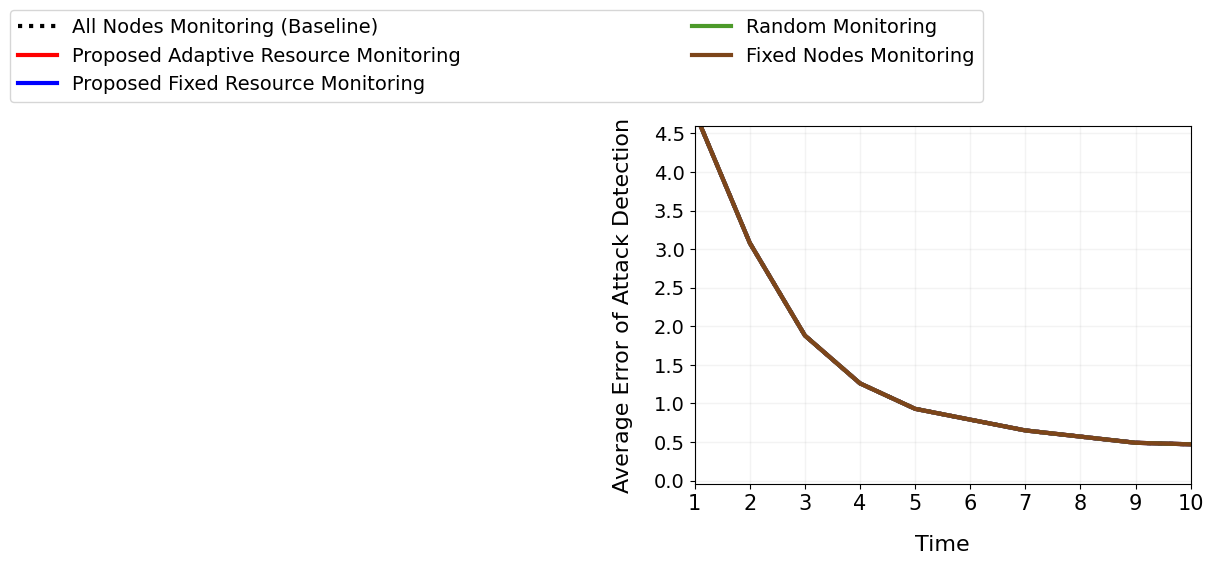

In [ ]:
plt.rcdefaults()

# plt.rcParams['figure.figsize'] = (6, 5)
fontsize = 16
for pack in packed_for_m:
  for mode in modes:
    (fixed, ours, random, alll, random_fixed, threshold) = pack

    # print(fixed)
    all_tot_err_list, mode_label, mode_color= mode_handler(mode, 2)
    mean_tot_err_list = np.zeros(T)
    for num in range(0, max_num):
      mean_tot_err_list += all_tot_err_list[num]
    mean_tot_err_list/= max_num
    X = np.arange(0, T)
    # plot
    linestyle = '-'
    if mode == 'all':
      linestyle='dotted'
    plt.plot(X, mean_tot_err_list, linewidth=3, label=mode_label, color=mode_color, linestyle=linestyle)

  # plt.legend(loc='best',prop={'size': fontsize-2} )
  # plt.legend(bbox_to_anchor=(0.105,0.5,0.96,0.5), loc="upper right", mode="expand", ncol= 1, prop={'size': fontsize-2})
  # plt.legend(bbox_to_anchor=(0.105,0.5,0.96,0.5), loc="upper right", mode="expand", ncol= 1, prop={'size': fontsize-2})
  plt.legend(bbox_to_anchor=(-1.4, 0, 2,1.35), loc='upper center', mode="expand", ncol= 2, prop={'size': fontsize-2})

  plt.xlim([0,T-1])
  plt.ylim([-0.05, 4.6])
  plt.xticks(ticks=X, labels=X+1, fontsize=fontsize-1)
  plt.ylabel(r'Average Error of Attack Detection', fontsize=fontsize, labelpad=15)
  plt.xlabel(r'Time', fontsize=fontsize, labelpad=15)
  plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
  plt.yticks(np.arange(0,4.6,0.5), fontsize=fontsize-2)
  axes=plt.gca()
  axes.set_aspect(7/5)
  plt.show()

### MSE

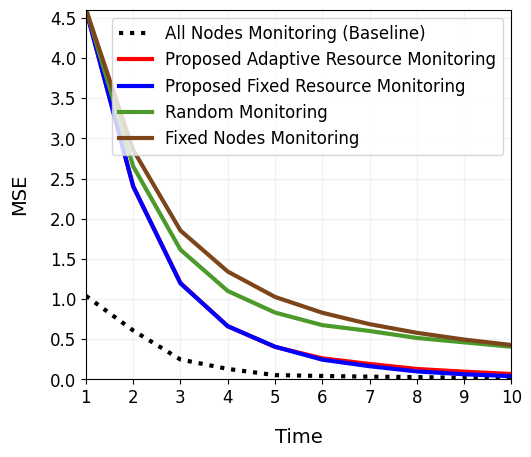

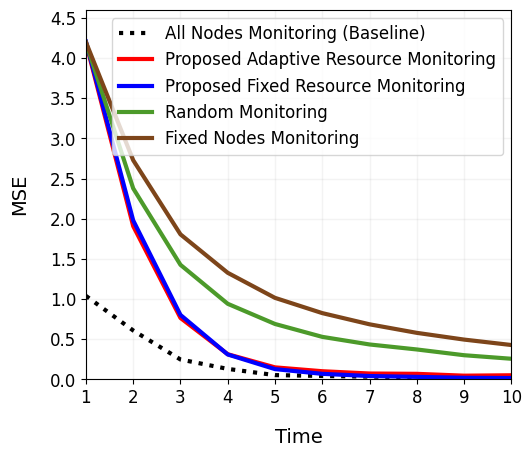

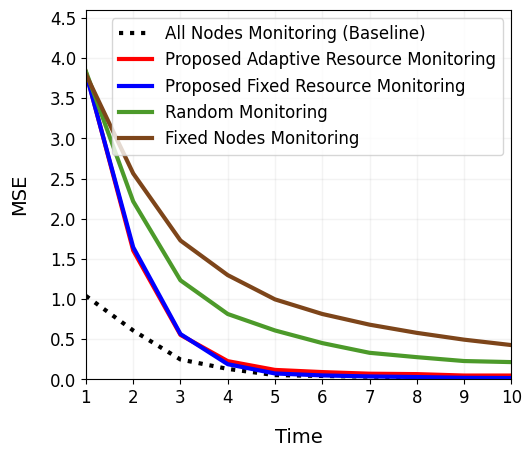

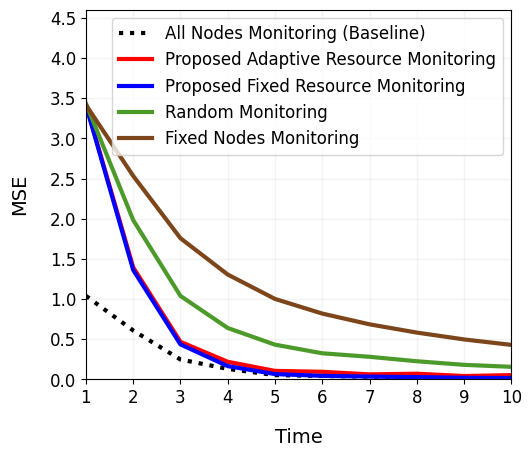

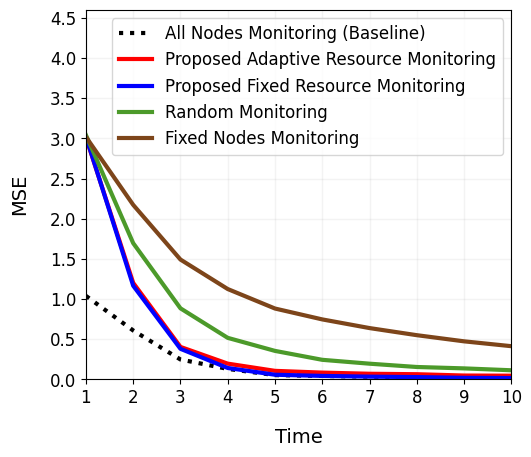

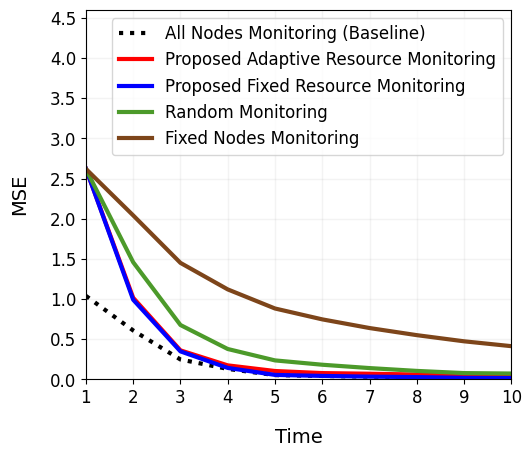

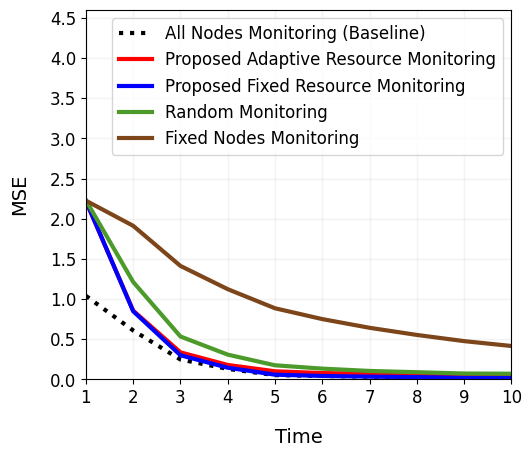

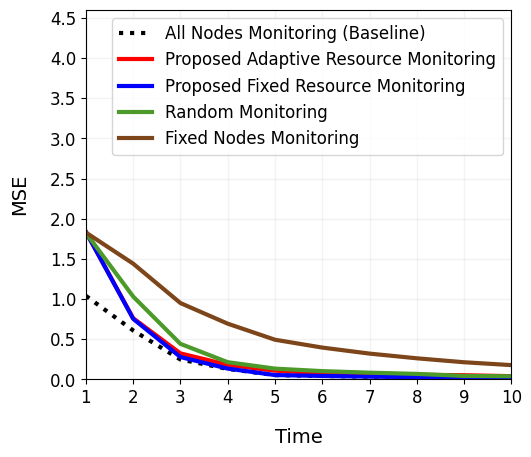

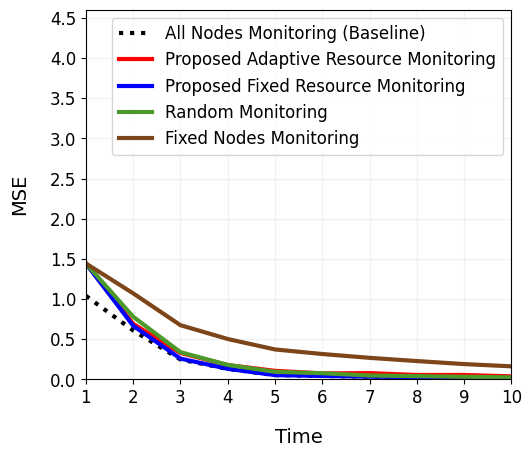

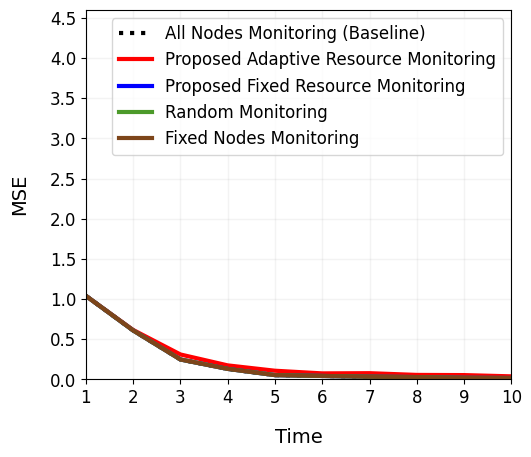

In [ ]:
plt.rcdefaults()
for pack in packed_for_m:
  for mode in modes:
    (fixed, ours, random, alll, random_fixed, threshold) = pack
    all_MSE_list, mode_label, mode_color = mode_handler(mode, 5)
    mean_MSE_list = np.zeros(T)
    for num in range(0, max_num):
      mean_MSE_list += all_MSE_list[num]
    mean_MSE_list/= max_num
    X = np.arange(0, T)
    linestyle = '-'
    if mode == 'all':
      linestyle='dotted'
    plt.plot(X, mean_MSE_list, linewidth=3, label=mode_label, color=mode_color, linestyle=linestyle)
  plt.legend(loc='best',prop={'size': fontsize-2} )
  plt.xlim([0,T-1])
  plt.ylim([0,4.6])

  # plt.xlim([0,25])

  # plt.rcParams['figure.figsize'] = [10,10]
  # plt.yticks(np.arange(0,T+1,0.5))
  plt.xticks(ticks=X, labels=X+1,  fontsize=fontsize-2)
  plt.ylabel(r'MSE', fontsize=fontsize, labelpad=15)
  plt.xlabel(r'Time', fontsize=fontsize, labelpad=15)
  plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
  axes=plt.gca()
  axes.set_aspect(1.7, adjustable='box')
  plt.yticks(np.arange(0,4.6,0.5),  fontsize=fontsize-2)
  plt.show()

### Total accuracy

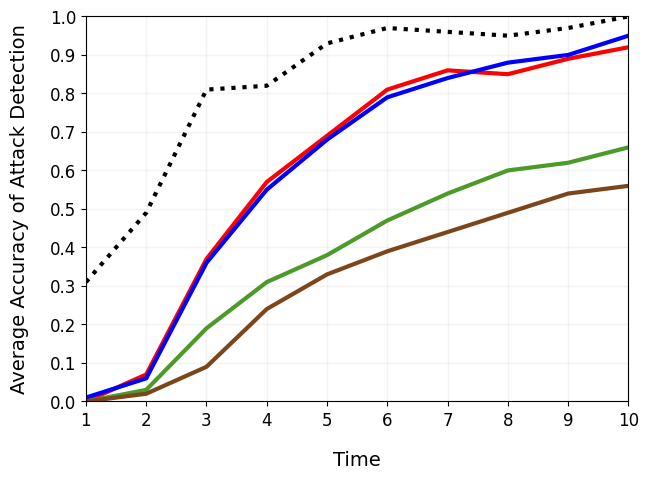

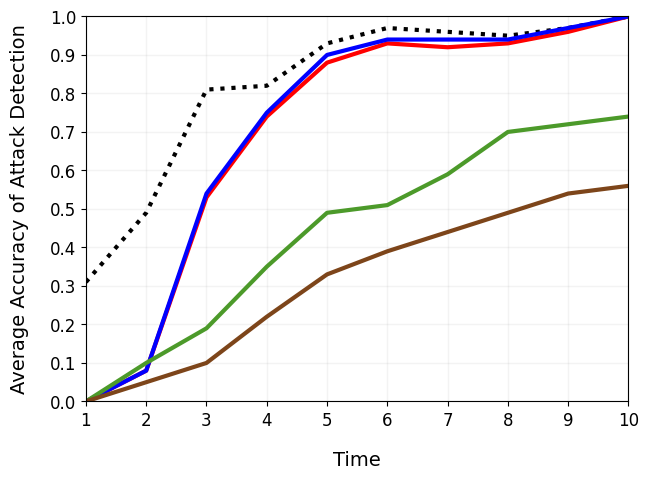

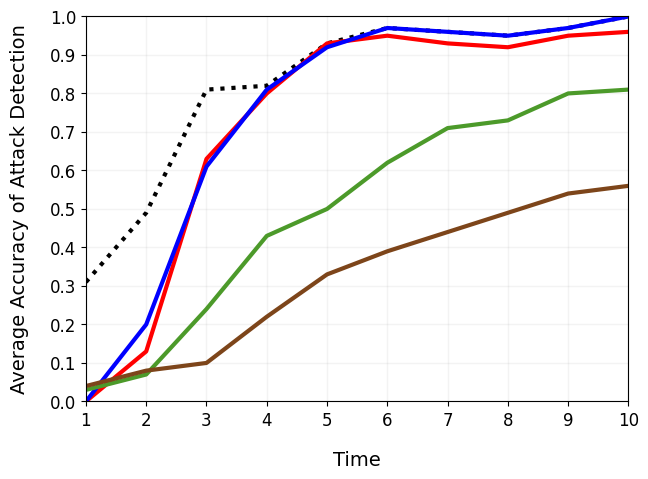

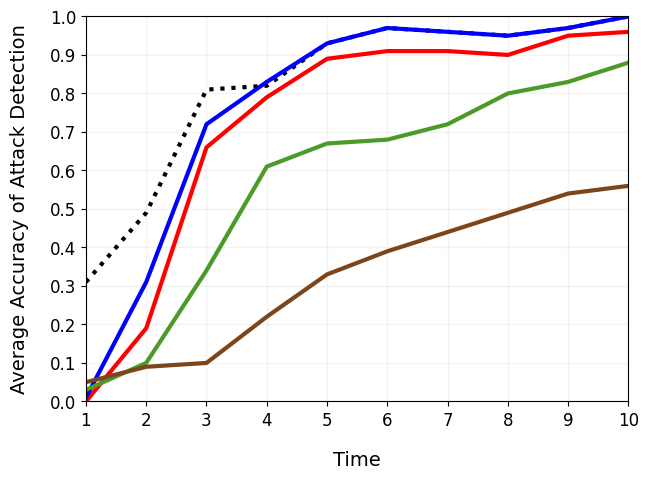

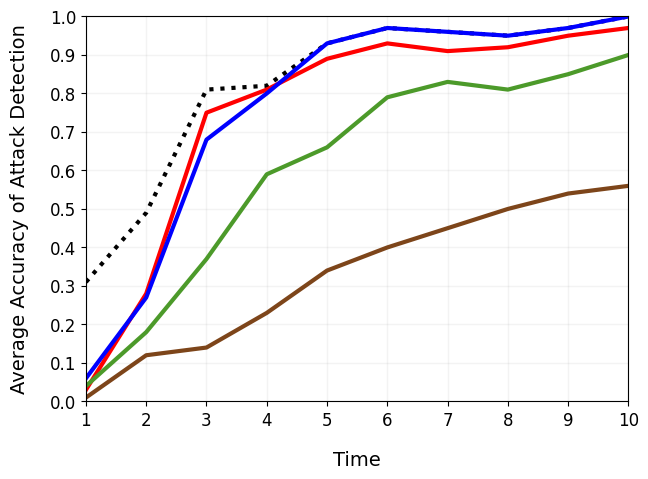

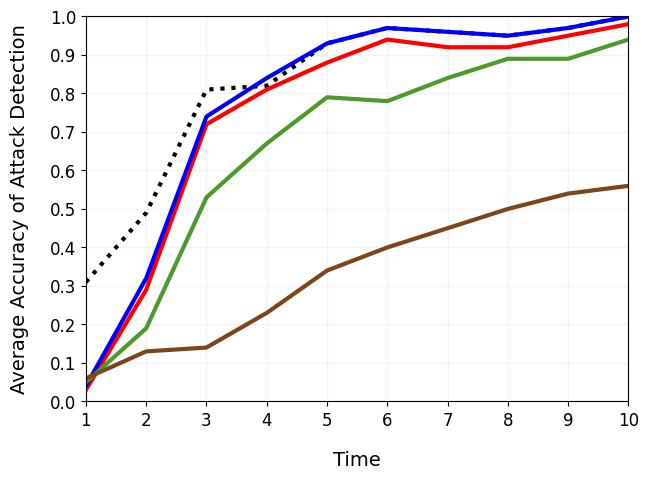

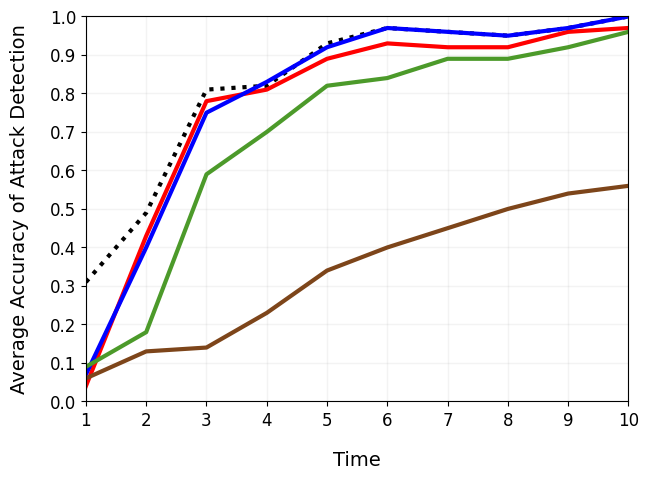

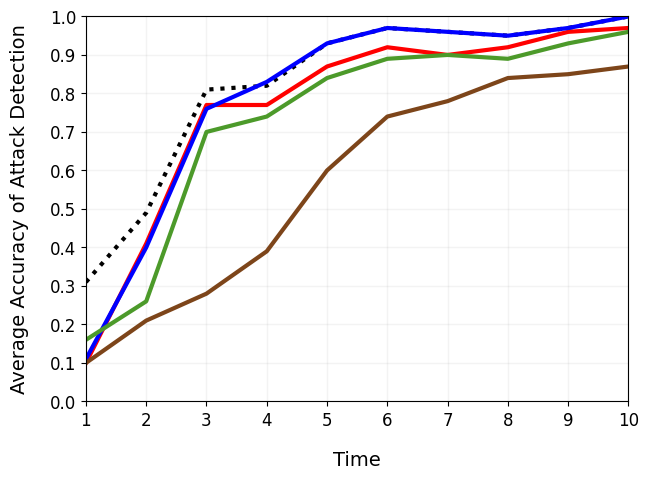

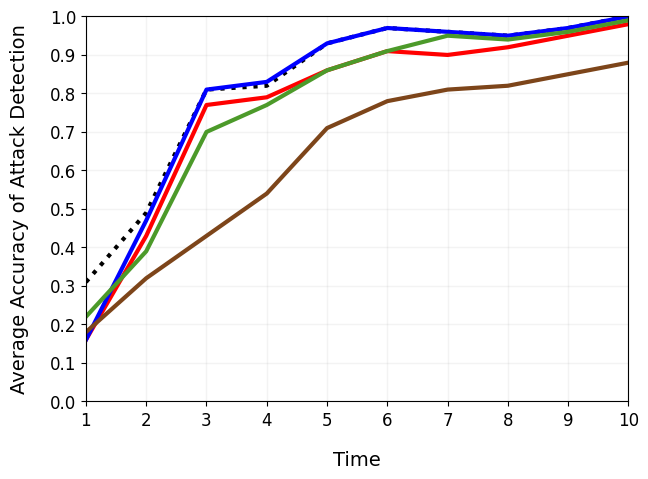

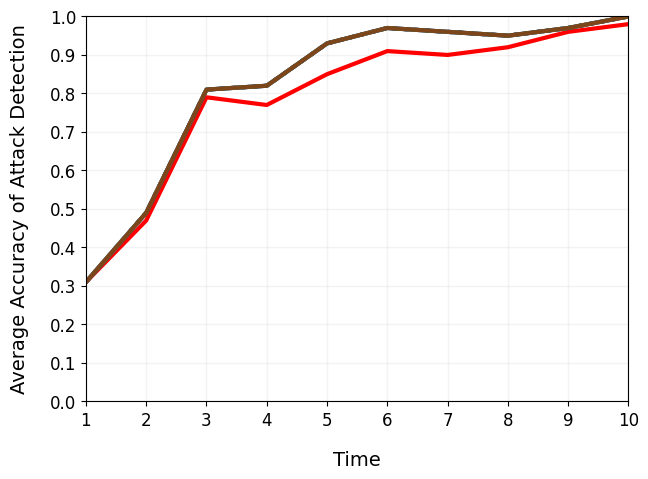

In [ ]:
# plt.rcdefaults()
plt.rcParams['figure.figsize'] = (7, 5)
for pack in packed_for_m:
  (fixed, ours, random, alll, random_fixed, threshold) = pack
  for mode in modes:
    all_acc_list, mode_label, mode_color = mode_handler(mode, 3)
    mean_acc_list = np.zeros(T)
    for num in range(0, max_num):
      mean_acc_list += all_acc_list[num]
    mean_acc_list/= max_num
    X = np.arange(0, T)
    linestyle = '-'
    if mode == 'all':
      linestyle='dotted'
    plt.plot(X, mean_acc_list, linewidth=3, label=mode_label, color=mode_color, linestyle=linestyle)
  yticks = np.arange(11)/10
  plt.xticks(ticks=X, labels=X+1, fontsize=fontsize-2)
  plt.ylabel(r'Average Accuracy of Attack Detection', fontsize=fontsize, labelpad=15)
  plt.xlabel(r'Time', fontsize=fontsize, labelpad=15)
  plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
  # plt.legend(loc='best',prop={'size': fontsize-2} )
  plt.xlim([0,T-1])
  plt.ylim([0.05,1])
  plt.yticks(ticks=yticks, labels=yticks, fontsize=fontsize-2)
  plt.show()

### Total accuracy + Together (m= 1, 4, 9)

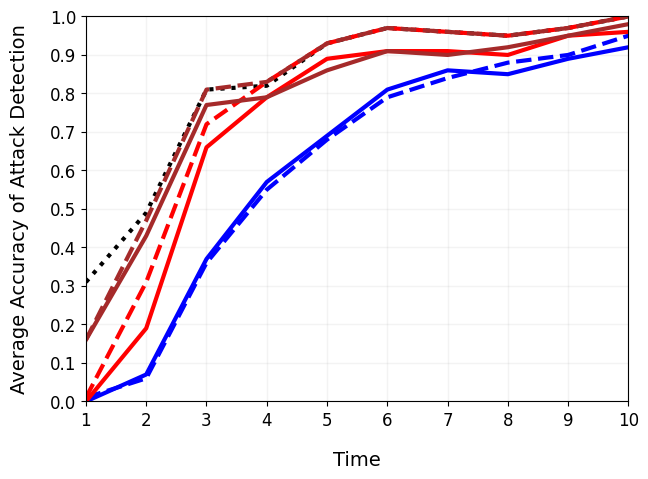

In [ ]:
# fontsize = 22
modes_color = ["#0000FF" , "#FF0000", "#A52A2A"]
m_bypass = 0
m_h = 0
one_time = False
for pack in packed_for_m:
  (fixed, ours, random, alll, random_fixed, threshold) = pack
  m_bypass += 1
  if (m_bypass != 1) and (m_bypass != 4) and (m_bypass != 9):
    continue
  m_h += 1
  for mode in modes:
    if (mode!="threshold" and mode!="ours" and mode!="all") or (mode=="all" and one_time): continue;
    all_acc_list, mode_label, mode_color = mode_handler(mode, 3)
    mean_acc_list = np.zeros(T)
    for num in range(0, max_num):
      mean_acc_list += all_acc_list[num]
    mean_acc_list/= max_num
    X = np.arange(0, T)
    linestyle = '-'
    if mode == 'all':
      linestyle='dotted'
      one_time = True
      mode_label = "All Nodes Monitoring (Baseline)"
      mode_color = "#000000"
    elif mode == 'threshold':
      mode_color = modes_color[m_h-1]
      mode_label = 'Adaptive Resource Monitoring ($m=$'+str(m_bypass) + ")"
    elif mode == 'ours':
      mode_color = modes_color[m_h-1]
      mode_label = 'Fixed Resource Monitoring ($m=$'+str(m_bypass) + ")"
      linestyle='dashed'
    plt.plot(X, mean_acc_list, linewidth=3, label=mode_label, color=mode_color, linestyle=linestyle)
yticks = np.arange(11)/10
plt.xticks(ticks=X, labels=X+1, fontsize=fontsize-2)
plt.ylabel(r'Average Accuracy of Attack Detection', fontsize=fontsize, labelpad=15)
plt.xlabel(r'Time', fontsize=fontsize, labelpad=15)
plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
# plt.legend(loc='best',prop={'size': fontsize-2} )
plt.xlim([0,T-1])
plt.ylim([0.05,1])
plt.yticks(ticks=yticks, labels=yticks, fontsize=fontsize-2)
plt.show()

### Node monitoring histogram

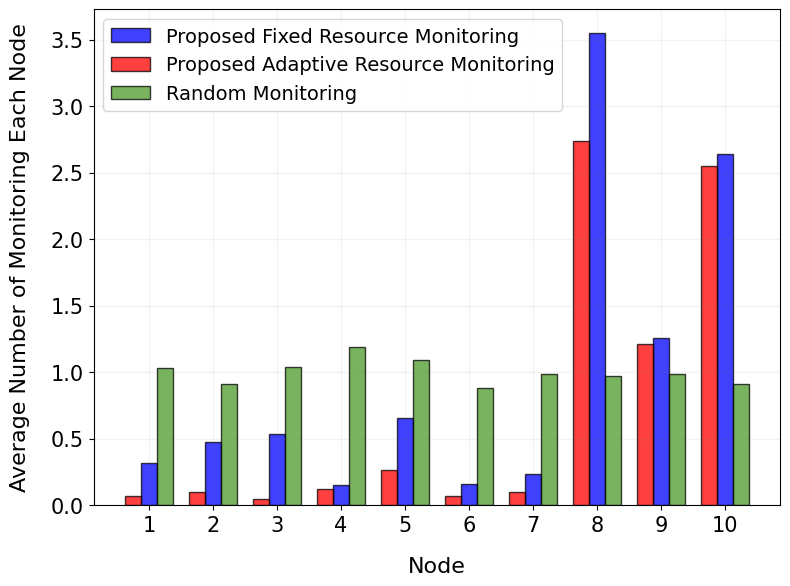

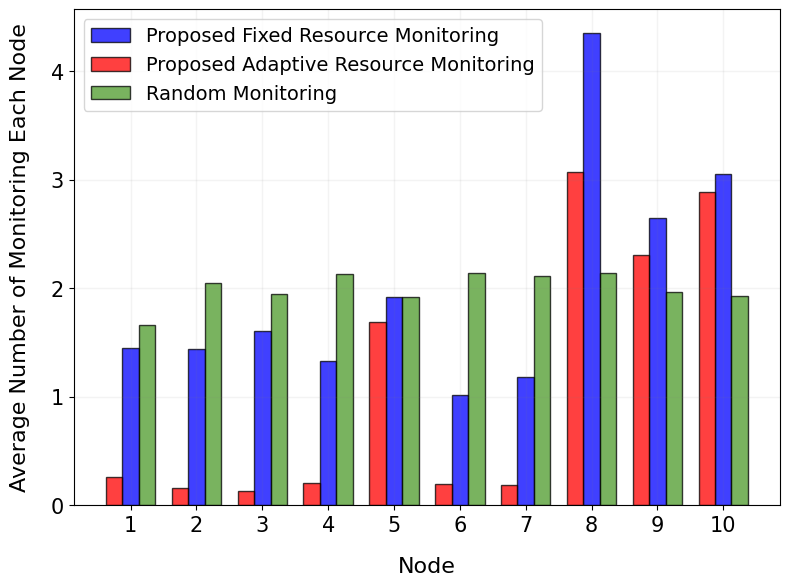

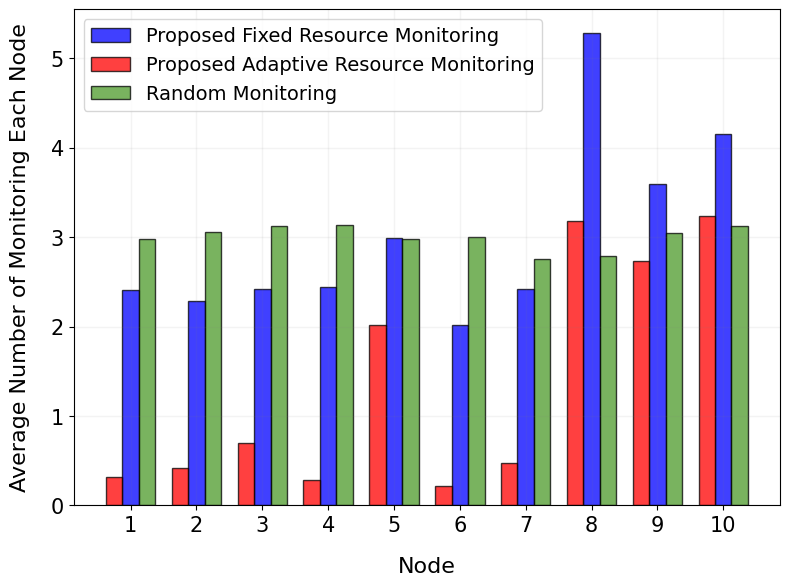

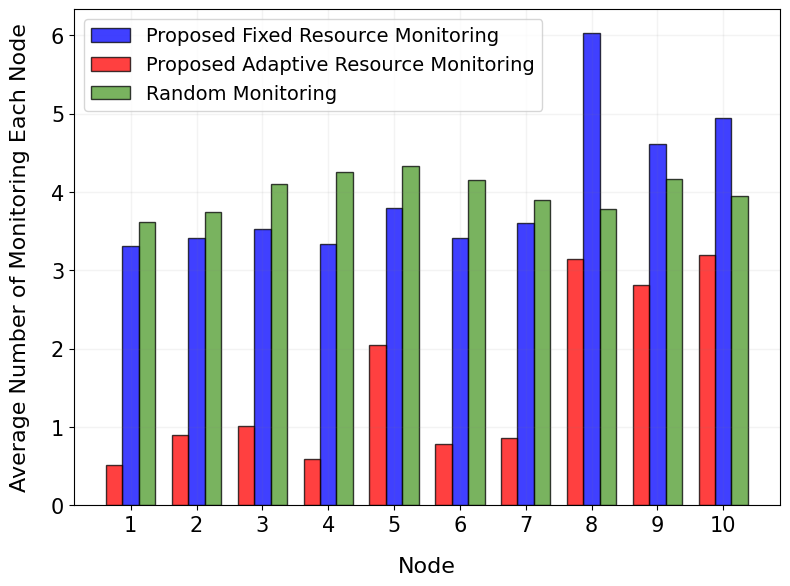

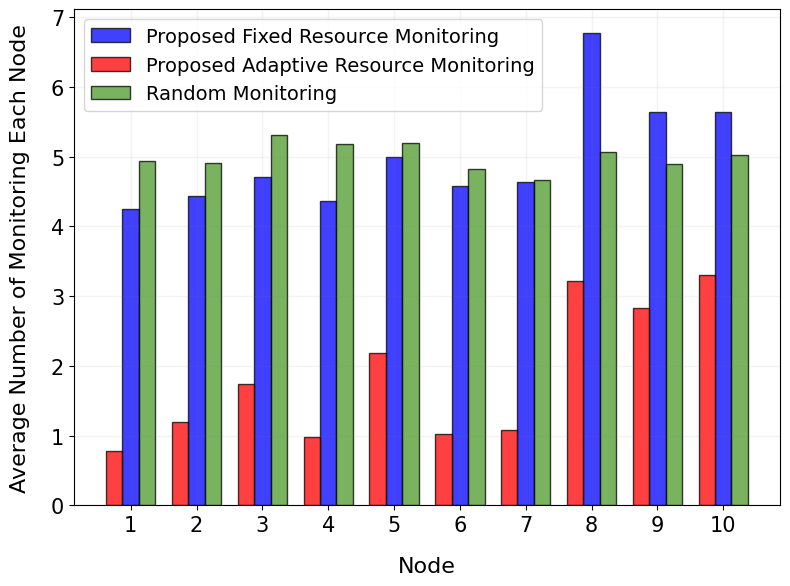

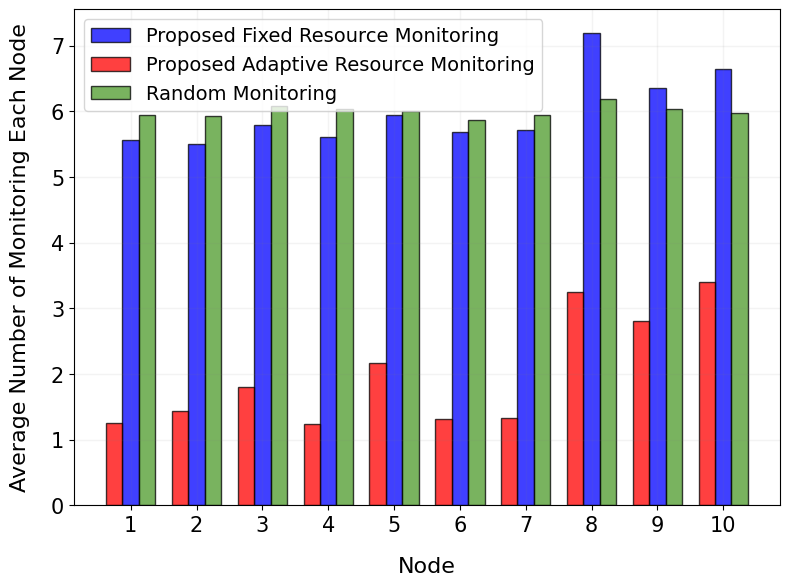

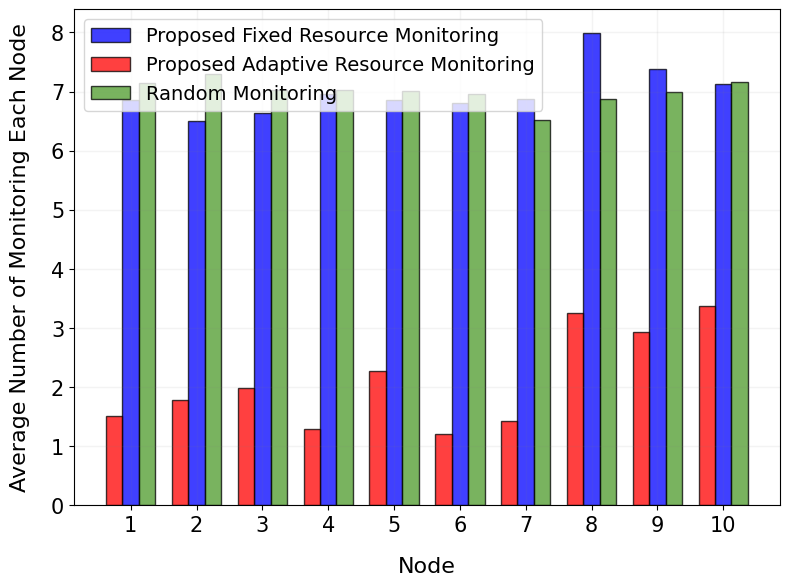

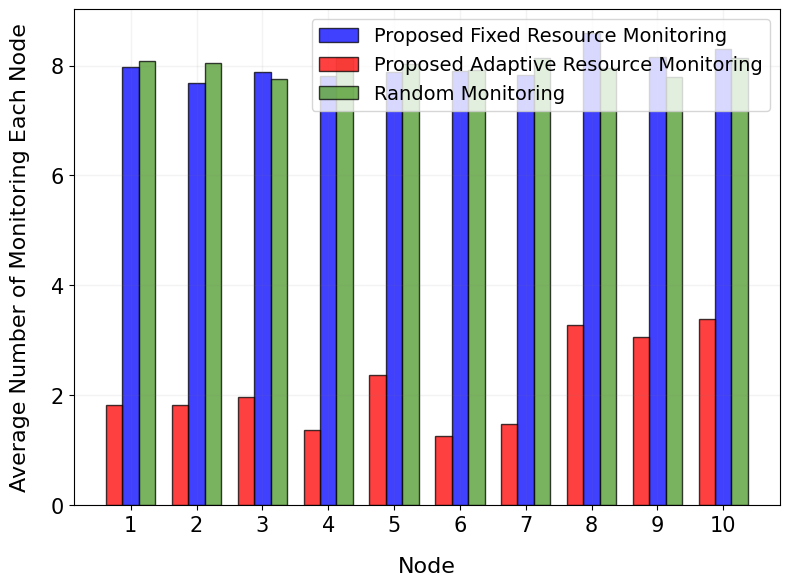

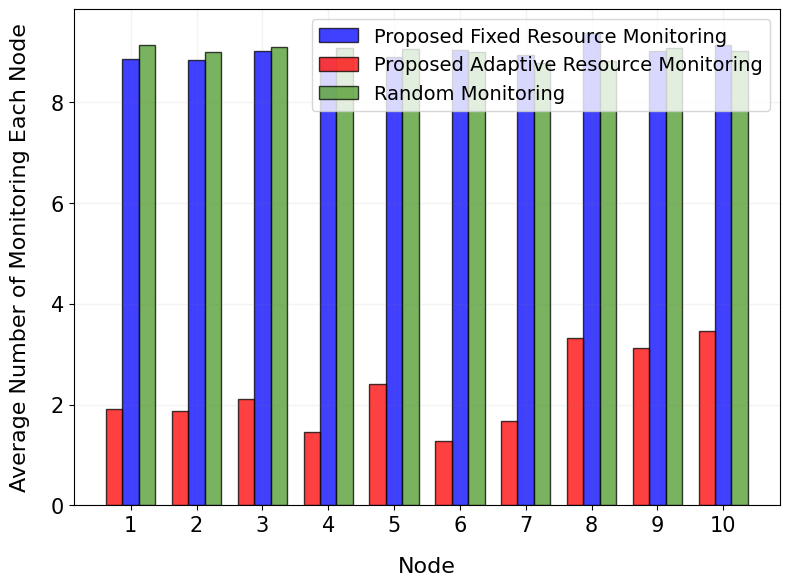

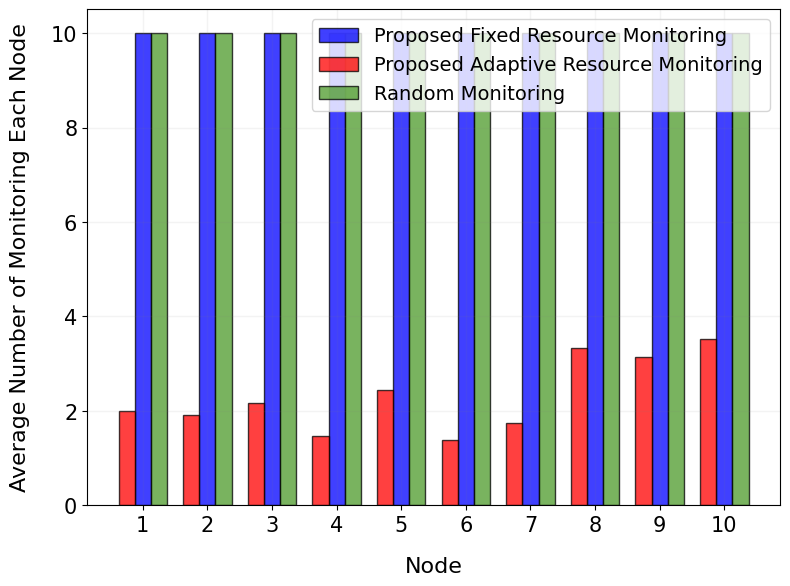

In [ ]:
plt.rcdefaults()
plt.rcParams['figure.figsize'] = [8,6]
for pack in packed_for_m:
  (fixed, ours, random, alll, random_fixed, threshold) = pack
  all_mon_list_threshold = threshold[4]
  all_mon_list_ours = ours[4]
  all_mon_list_random_fixed = random_fixed[4]
  fontsize = 16
  occurance_threshold = np.zeros(N)
  occurance_ours = np.zeros(N)
  occurance_random_fixed = np.zeros(N)

  for i in range(0, N):
    for arr in all_mon_list_threshold:
      for arr2 in arr:
        occurance_threshold[i] += np.sum(arr2 == i)
  for i in range(0, N):
    for arr in all_mon_list_ours:
      for arr2 in arr:
          occurance_ours[i] += np.sum(arr2 == i)
  for i in range(0, N):
    for arr in all_mon_list_random_fixed:
        for arr2 in arr:
          occurance_random_fixed[i] += np.sum(arr2 == i)

  width = 0.25  # the width of the bars
  # mean_mon_list_threshold = occurance_threshold
  # mean_mon_list_ours = occurance_ours
  mean_mon_list_threshold = occurance_threshold/max_num
  mean_mon_list_ours = occurance_ours/max_num
  mean_mon_list_random_fixed =occurance_random_fixed/max_num
  fig1, ax1 = plt.subplots()
  rects2 = ax1.bar(np.arange(N), mean_mon_list_ours, width ,label=mode_labels[0],color=mode_colors[0], alpha=0.75, edgecolor="black")
  rects1 = ax1.bar(np.arange(N)-width, mean_mon_list_threshold, width, label=mode_labels[1],color=mode_colors[1], alpha=0.75,edgecolor="black" )
  rects3 = ax1.bar(np.arange(N)+width, mean_mon_list_random_fixed, width, label=mode_labels[2],color=mode_colors[2], alpha=0.75,edgecolor="black" )

  ax1.set_xticks(np.arange(N))
  ax1.yaxis.set_tick_params(labelsize=fontsize-1)
  ax1.set_xticklabels(np.arange(N)+1, fontsize=fontsize-1)
  ax1.set_ylabel(r'Average Number of Monitoring Each Node', fontsize=fontsize, labelpad=15)
  ax1.set_xlabel(r'Node', fontsize=fontsize, labelpad=15)
  ax1.legend(prop={'size': fontsize-2})
  ax1.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
  fig1.tight_layout()
# plt.show()



### Adaptive Resource Monitoring

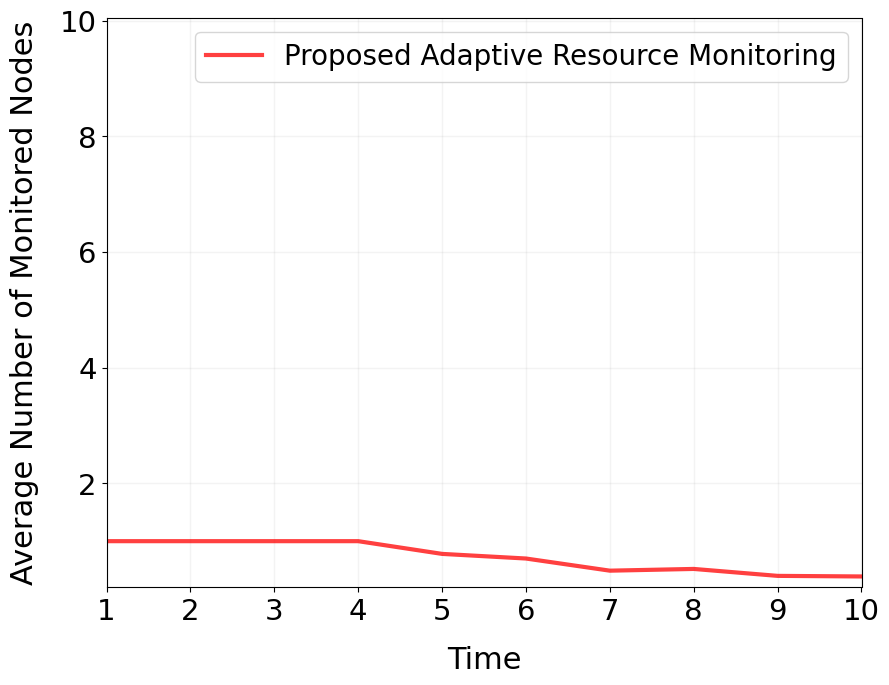

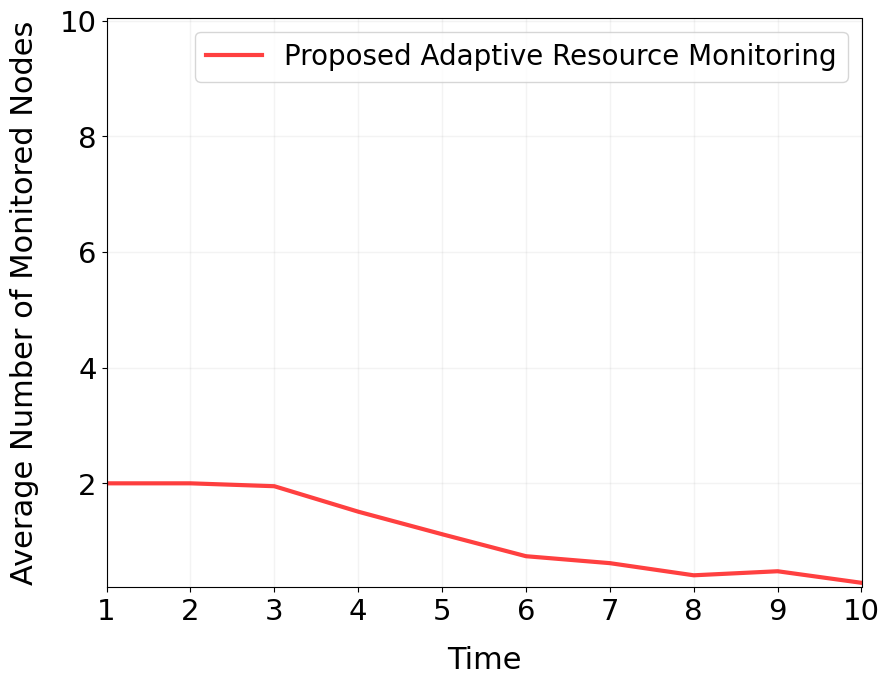

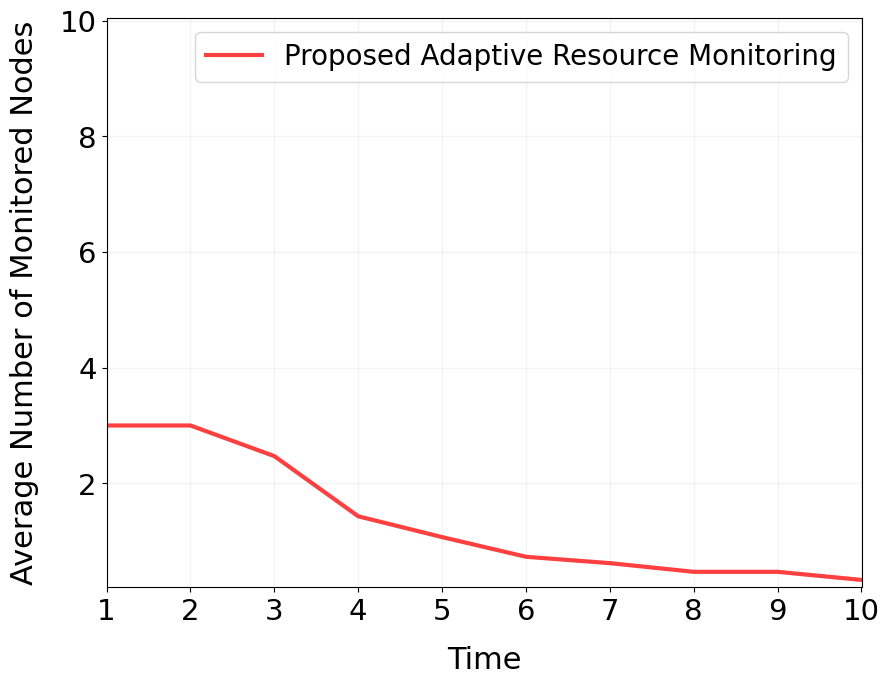

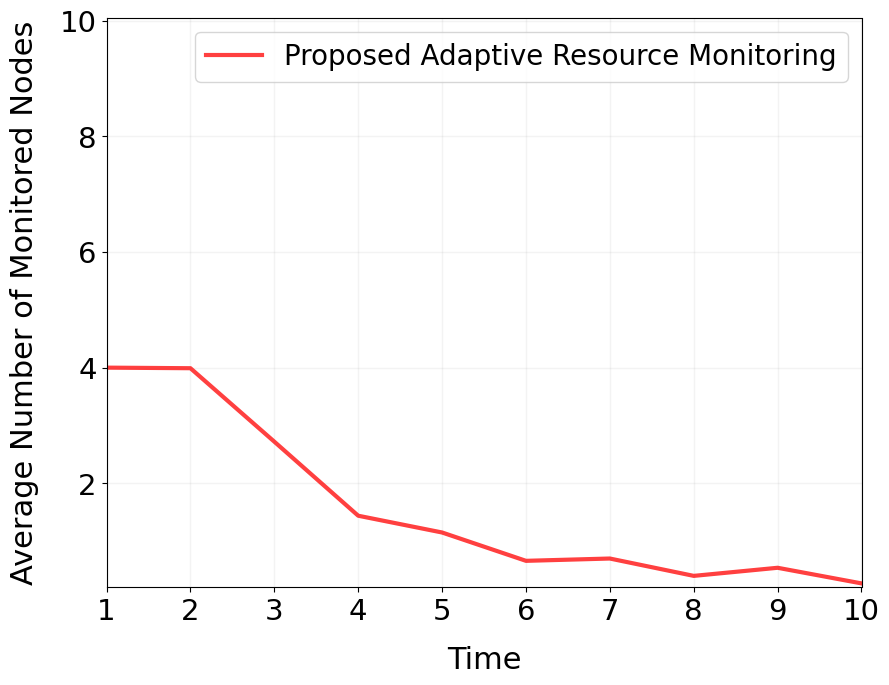

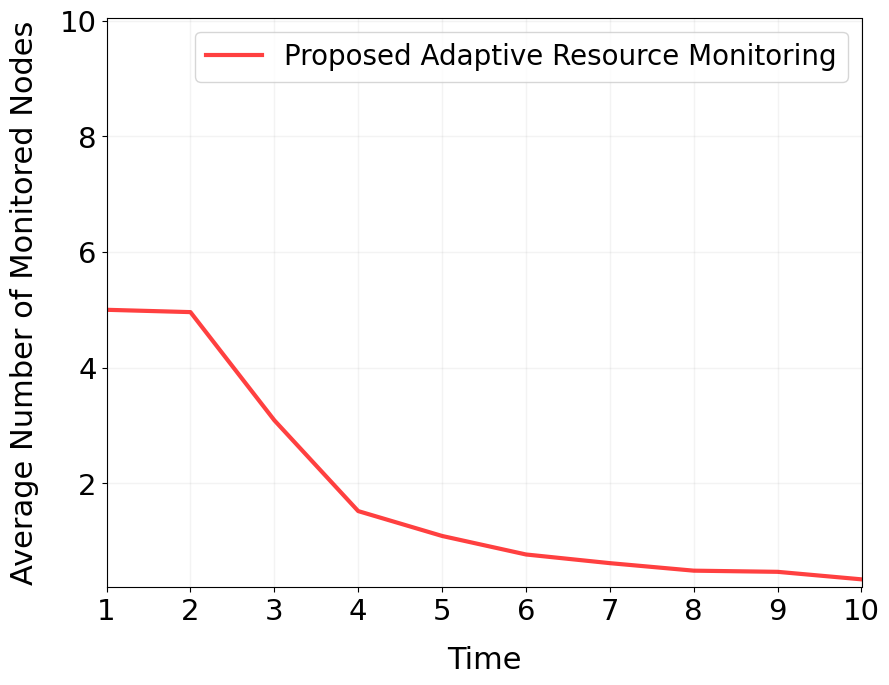

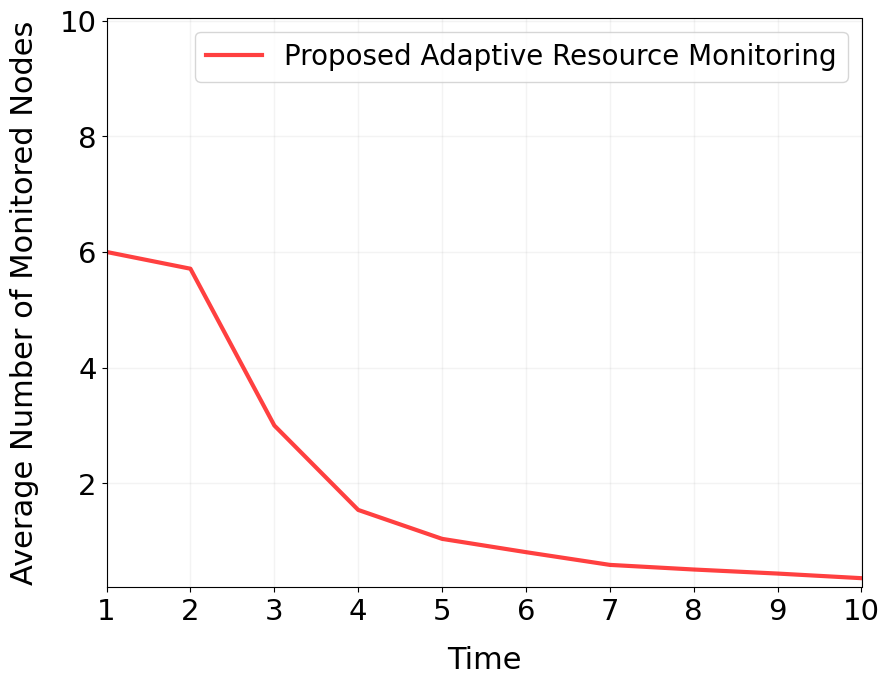

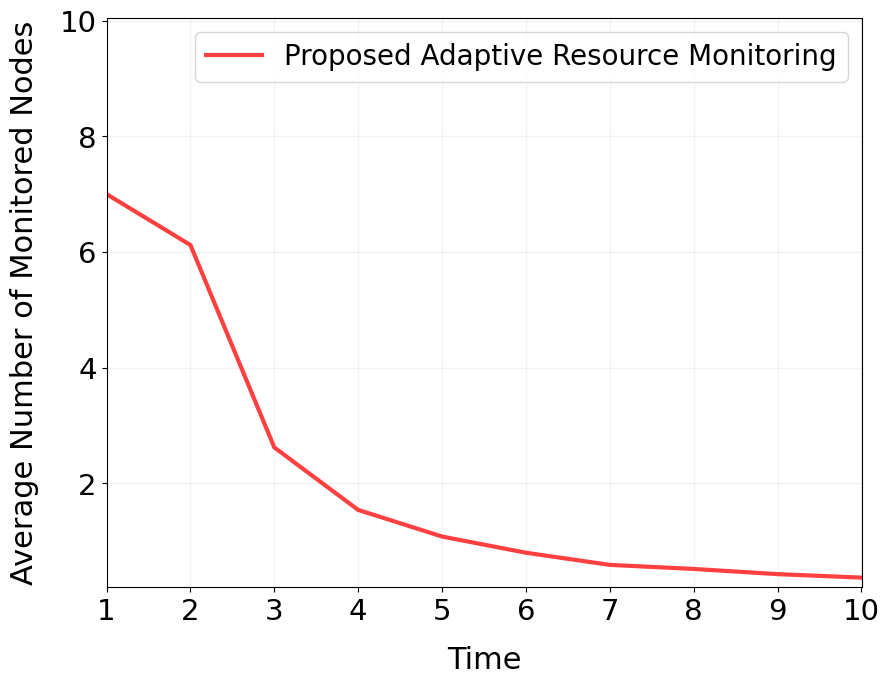

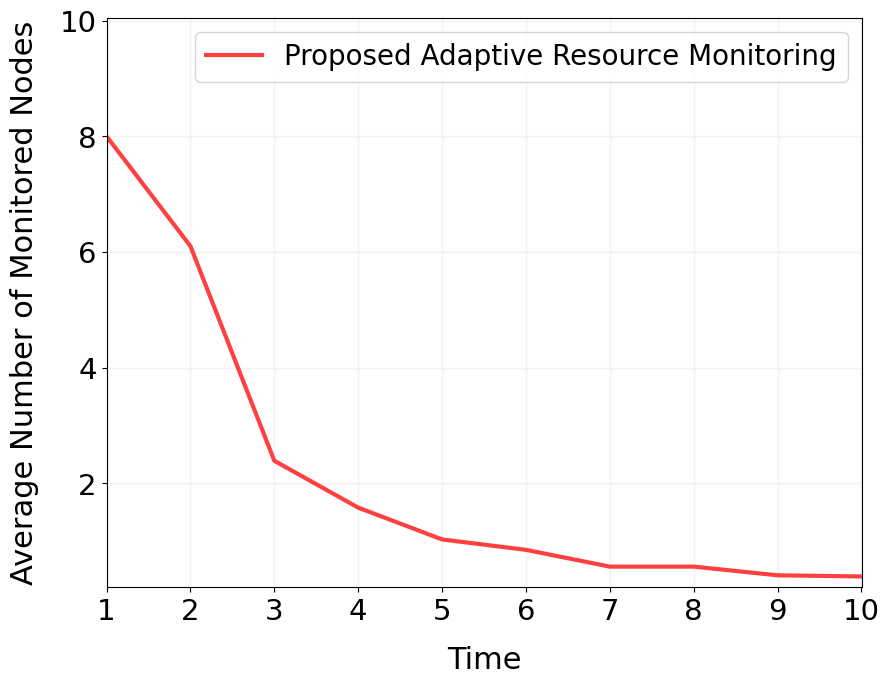

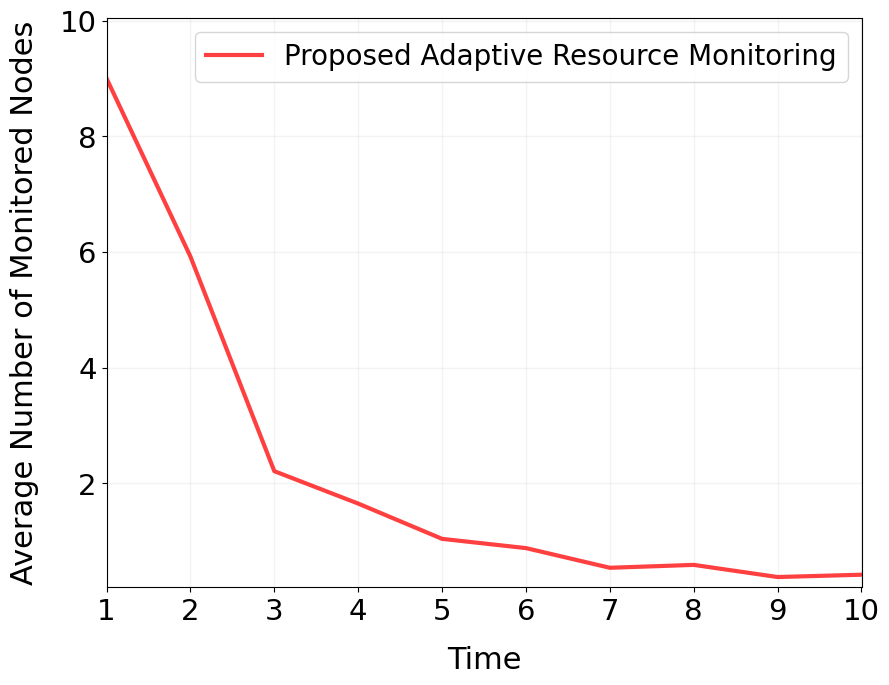

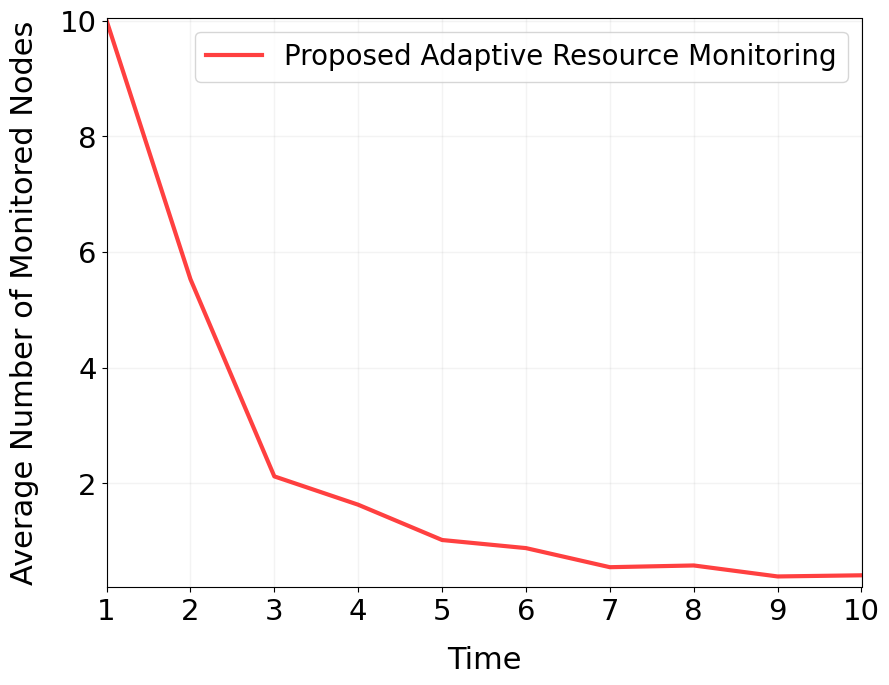

In [ ]:
plt.rcdefaults()
plt.rcParams['figure.figsize'] = [9,7]

for pack in packed_for_m:
  (fixed, ours, random, alll, random_fixed, threshold) = pack
  all_mon_list_threshold = threshold[4]

  fontsize = 22
  occurance_threshold = np.zeros(T)
  i =0
  for arr in all_mon_list_threshold:
    i = 0
    for arr2 in arr:
      occurance_threshold[i] += len(arr2)
      i += 1

  width = 2.5  # the width of the bars
  # mean_mon_list_threshold = occurance_threshold
  # mean_mon_list_ours = occurance_ours
  mean_mon_list_threshold = occurance_threshold/max_num

  fig1, ax1 = plt.subplots()
  rects1 = ax1.plot(np.arange(N), mean_mon_list_threshold, linewidth=3, label=mode_labels[1],color=mode_colors[1], alpha=0.75 )
  ax1.set_xticks(np.arange(N))
  ax1.yaxis.set_tick_params(labelsize=fontsize-1)
  ax1.set_xticklabels(np.arange(N)+1, fontsize=fontsize-1)
  ax1.set_ylabel(r'Average Number of Monitored Nodes', fontsize=fontsize, labelpad=15)
  ax1.set_xlabel(r'Time', fontsize=fontsize, labelpad=15)
  ax1.legend(prop={'size': fontsize-2})
  ax1.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
  plt.xlim([0,T-1])
  plt.ylim([0.2,m+0.05])
  fig1.tight_layout()
  plt.show()


### Adaptive Resource Monitoring + Together (m= 1, 4, 9)

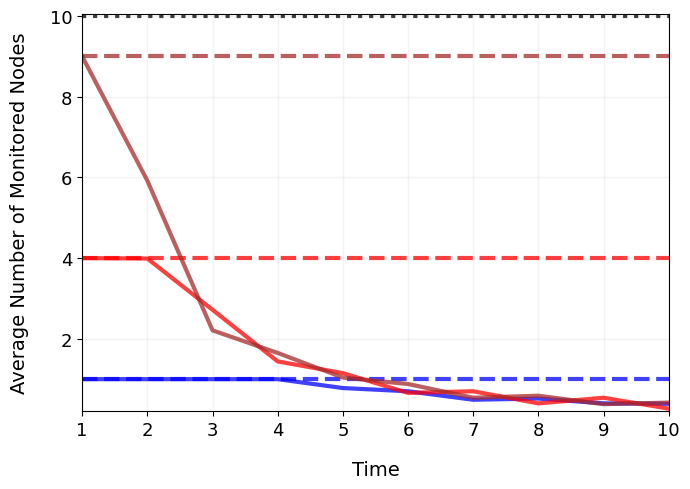

In [ ]:
plt.rcdefaults()
plt.rcParams['figure.figsize'] = [7, 5]

fig1, ax1 = plt.subplots()
m_mode_colors = ["#0000FF" , "#FF0000", "#A52A2A"]
m_bypass = 0
m_h = 0

for pack in packed_for_m:
  m_bypass += 1
  if (m_bypass != 1) and (m_bypass != 4) and (m_bypass != 9):
    continue
  m_h += 1
  (fixed, ours, random, alll, random_fixed, threshold) = pack
  all_mon_list_threshold = threshold[4]

  fontsize = 14
  occurance_threshold = np.zeros(T)
  i =0
  # for i in range(0, T):
  for arr in all_mon_list_threshold:
    i = 0
    for arr2 in arr:
      occurance_threshold[i] += len(arr2)
      # print(len(arr2))
      i += 1

  width = 2.5  # the width of the bars
  # mean_mon_list_threshold = occurance_threshold
  # mean_mon_list_ours = occurance_ours
  mean_mon_list_threshold = occurance_threshold/max_num
  label = 'Adaptive Resource Monitoring ($m=$'+str(m_bypass) + ")"
  ax1.plot(np.arange(N), mean_mon_list_threshold, linewidth=3, label=label,color=m_mode_colors[m_h-1], alpha=0.75)
  label = 'Fixed Resource Monitoring ($m=$'+str(m_bypass) + ")"
  ax1.plot(np.arange(N), np.arange(N)*0 + m_bypass, linewidth=3, label=label,color=m_mode_colors[m_h-1], alpha=0.75, linestyle = "dashed" )

ax1.plot(np.arange(N), np.arange(N)*0 + 10, linewidth=3, label="All Nodes Monitoring (Baseline)",color=mode_colors[4], alpha=0.75, linestyle = "dotted" )

ax1.set_xticks(np.arange(N))
ax1.yaxis.set_tick_params(labelsize=fontsize-1)
ax1.set_xticklabels(np.arange(N)+1, fontsize=fontsize-1)
ax1.set_ylabel(r'Average Number of Monitored Nodes', fontsize=fontsize, labelpad=15)
ax1.set_xlabel(r'Time', fontsize=fontsize, labelpad=15)
# ax1.legend(bbox_to_anchor=(-1.4, 0.1, 2,2), loc='upper center', mode="expand", ncol= 2, prop={'size': fontsize-2})
ax1.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
plt.xlim([0,T-1])
plt.ylim([0.2,N+0.05])
fig1.tight_layout()


plt.show()


### Average total num of monitored nodes

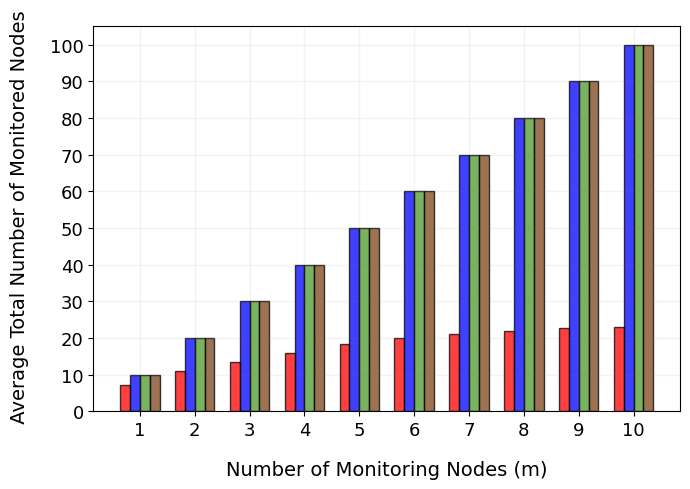

In [ ]:
plt.rcdefaults()
plt.rcParams['figure.figsize'] = [7,5]
fig1, ax1 = plt.subplots()
fontsize = 14
mean_of_mean = np.zeros(m)
l = (len(modes)-1)/2
j=0
for mode in modes:
  if mode == 'all':
    continue
  i=0
  num = np.zeros(N)
  for pack in packed_for_m:
    mean_of_mean = np.zeros(m)

    i += 1
    (fixed, ours, random, alll, random_fixed, threshold) = pack
    all_mon_list, mode_label, mode_color= mode_handler(mode, 4)
    for arr in all_mon_list:
      for arr2 in arr:
        num[i-1] += len(arr2)

  num = num/(max_num)
  width = 0.18  # the width of the bars
  j += 1
    # mean_mon_list_random_fixed =occurance_random_fixed/max_num
  rects2 = ax1.bar(np.arange(N) + (-width*l + (j)*width - width/2 ), num, width ,label=mode_label,color=mode_color, alpha=0.75, edgecolor="black")
ax1.set_xticks(np.arange(N))
ax1.set_yticks(np.arange(N+1)*T)
ax1.yaxis.set_tick_params(labelsize=fontsize-1)
ax1.set_xticklabels(np.arange(N)+1, fontsize=fontsize-1)
ax1.set_ylabel(r' Average Total Number of Monitored Nodes', fontsize=fontsize, labelpad=15)
ax1.set_xlabel(r'Number of Monitoring Nodes (m)', fontsize=fontsize, labelpad=15)
# ax1.legend(bbox_to_anchor=(-1.2, 0.2, 2,2.35), loc='upper center', mode="expand", ncol= 2, prop={'size': fontsize-2})
ax1.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
fig1.tight_layout()
plt.show()

### Average total error

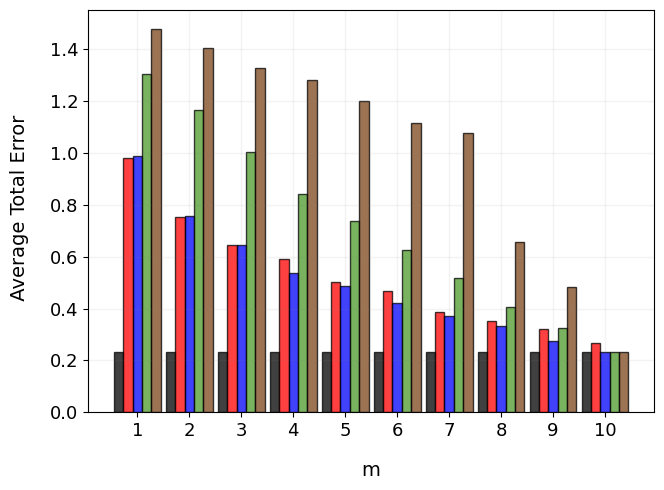

In [ ]:
plt.rcdefaults()
plt.rcParams['figure.figsize'] = [7,5]

fig1, ax1 = plt.subplots()
# all_mon_list_random_fixed = random_fixed[4]
fontsize = 14
mean_of_mean = np.zeros(m)
num_ours = np.zeros(m)
# num_random_fixed = np.zeros(m)
l = len(modes)/2
j=0
for mode in modes:
  mean_of_mean = np.zeros(N)
  i=0
  for pack in packed_for_m:

    i += 1
    (fixed, ours, random, alll, random_fixed, threshold) = pack
    all_tot_err_list, mode_label, mode_color= mode_handler(mode, 2)
    mean_tot_err_list = np.zeros(T)
    for num in range(0, max_num):
      mean_tot_err_list += all_tot_err_list[num]
    mean_of_mean[i-1] = np.sum(mean_tot_err_list)/(T  * max_num)

    width = 0.18  # the width of the bars
  j += 1
  # mean_mon_list_random_fixed =occurance_random_fixed/max_num
  rects2 = ax1.bar(np.arange(N) + (-width*l + (j)*width - width/2), mean_of_mean, width ,label=mode_label,color=mode_color, alpha=0.75, edgecolor="black")
  # rects1 = ax1.bar(np.arange(m)+width/2, mean_mon_list_threshold, width, label=mode_labels[1],color=mode_colors[1], alpha=0.75,edgecolor="black" )
  # # rects3 = ax1.bar(np.arange(m)+width, mean_mon_list_random_fixed, width, label=mode_labels[2],color=mode_colors[2], alpha=0.75,edgecolor="black" )
ax1.set_xticks(np.arange(N))
ax1.yaxis.set_tick_params(labelsize=fontsize-1)
ax1.set_xticklabels(np.arange(N)+1, fontsize=fontsize-1)
ax1.set_ylabel(r' Average Total Error', fontsize=fontsize, labelpad=15)
ax1.set_xlabel(r'm', fontsize=fontsize, labelpad=15)
# ax1.legend(bbox_to_anchor=(-1.2, 0.2, 2,2.35), loc='upper center', mode="expand", ncol= 2, prop={'size': fontsize-2})
ax1.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
fig1.tight_layout()
axes=plt.gca()
axes.set_aspect(5, adjustable='box')
plt.show()


## Plots for Different $q$

In [ ]:
from pickle import FALSE
packed_for_q_list = []
q_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
first_time = False
for q in q_list:
  packed_for_m = np.load('packed_for_m2q' + str(q) + '.npy', allow_pickle=True)
  for pack in packed_for_m:
    if first_time:
      break
    if q == 0.2:
      first_time = True
      continue
    break
  packed_for_q_list.append(pack)

### Average Total Error - Measuring Noise error (q) - bar

In [ ]:
fixed, ours, random, alll, random_fixed, threshold = [], [], [], [], [], []
modes = ['all', 'threshold', 'ours', 'random_fixed', 'fixed']

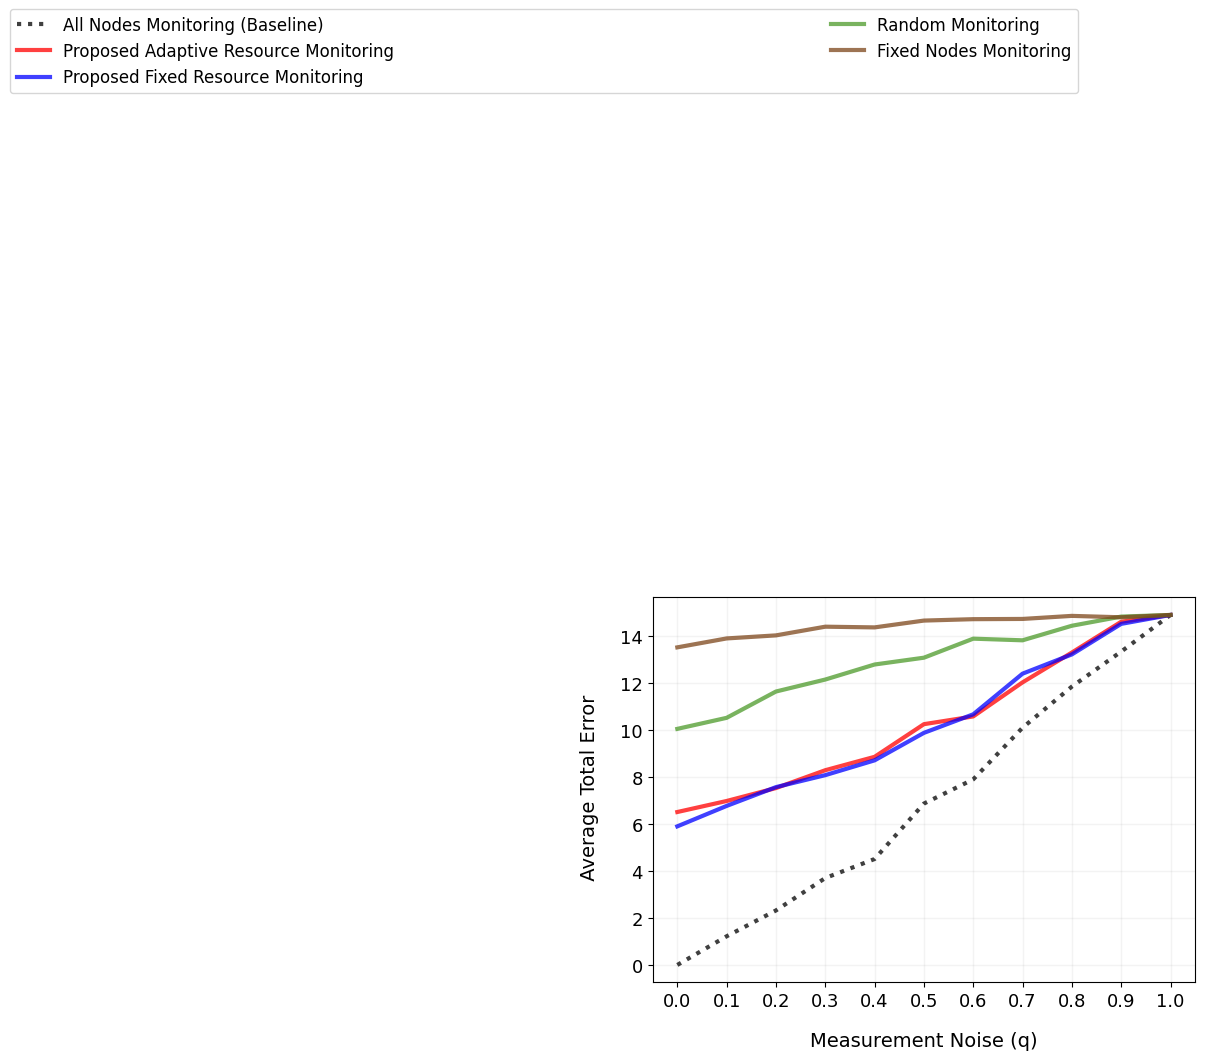

In [ ]:
# all_mon_list_random_fixed = random_fixed[4]
plt.rcdefaults()
plt.rcParams['figure.figsize'] = [7,5]
fig1, ax1 = plt.subplots()
fontsize = 14
mean_of_mean = np.zeros(m)
l = len(modes)/2
j=0
for mode in modes:
  mean_of_mean = np.zeros(len(q_list))
  i=0
  for pack in packed_for_q_list:
    i += 1
    # print(pack[0][0][2])
    (fixed, ours, random, alll, random_fixed, threshold) = pack
    # print(fixed[4][0][0])
    # print(random[4])
    all_tot_err_list, mode_label, mode_color= mode_handler(mode, 2)
    mean_tot_err_list = np.zeros(T)
    for num in range(0, max_num):
      # print(all_tot_err_list[num])
      mean_tot_err_list += all_tot_err_list[num]
    # mean_of_mean[i-1] = np.sum(mean_tot_err_list)/(T  * max_num)
    mean_of_mean[i-1] = np.sum(mean_tot_err_list)/(max_num)
    # print(mean_of_mean)
    width = 0.009  # the width of the bars
    j += 1
    # mean_mon_list_random_fixed =occurance_random_fixed/max_num
    # rects2 = ax1.bar(np.arange(len(q_list)) + (-width*l + (j)*width  - width/2), mean_of_mean, width ,label=mode_label,color=mode_color, alpha=0.75, edgecolor="black")
    # print(mean_of_mean)
  linestyle = "solid"
  if mode=='all':
    linestyle = "dotted"
  rects2 = ax1.plot(np.array(q_list) , mean_of_mean, linewidth = 3 ,label=mode_label,color=mode_color, alpha=0.75, linestyle =linestyle)
  # rects1 = ax1.bar(np.arange(m)+width/2, mean_mon_list_threshold, width, label=mode_labels[1],color=mode_colors[1], alpha=0.75,edgecolor="black" )
  # # rects3 = ax1.bar(np.arange(m)+width, mean_mon_list_random_fixed, width, label=mode_labels[2],color=mode_colors[2], alpha=0.75,edgecolor="black" )

ax1.set_xticks(np.array(q_list))
ax1.yaxis.set_tick_params(labelsize=fontsize-1)
ax1.set_xticklabels(np.array(q_list), fontsize=fontsize-1)
ax1.set_ylabel(r' Average Total Error', fontsize=fontsize, labelpad=15)
ax1.set_xlabel(r'Measurement Noise (q)', fontsize=fontsize, labelpad=15)
ax1.legend(bbox_to_anchor=(-1.2, 0.2, 2,2.35), loc='upper center', mode="expand", ncol= 2, prop={'size': fontsize-2})
ax1.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
plt.show()


### Average total num of monitored nodes (q)


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


<ipython-input-148-c7dcfb53e207>:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig1.tight_layout()


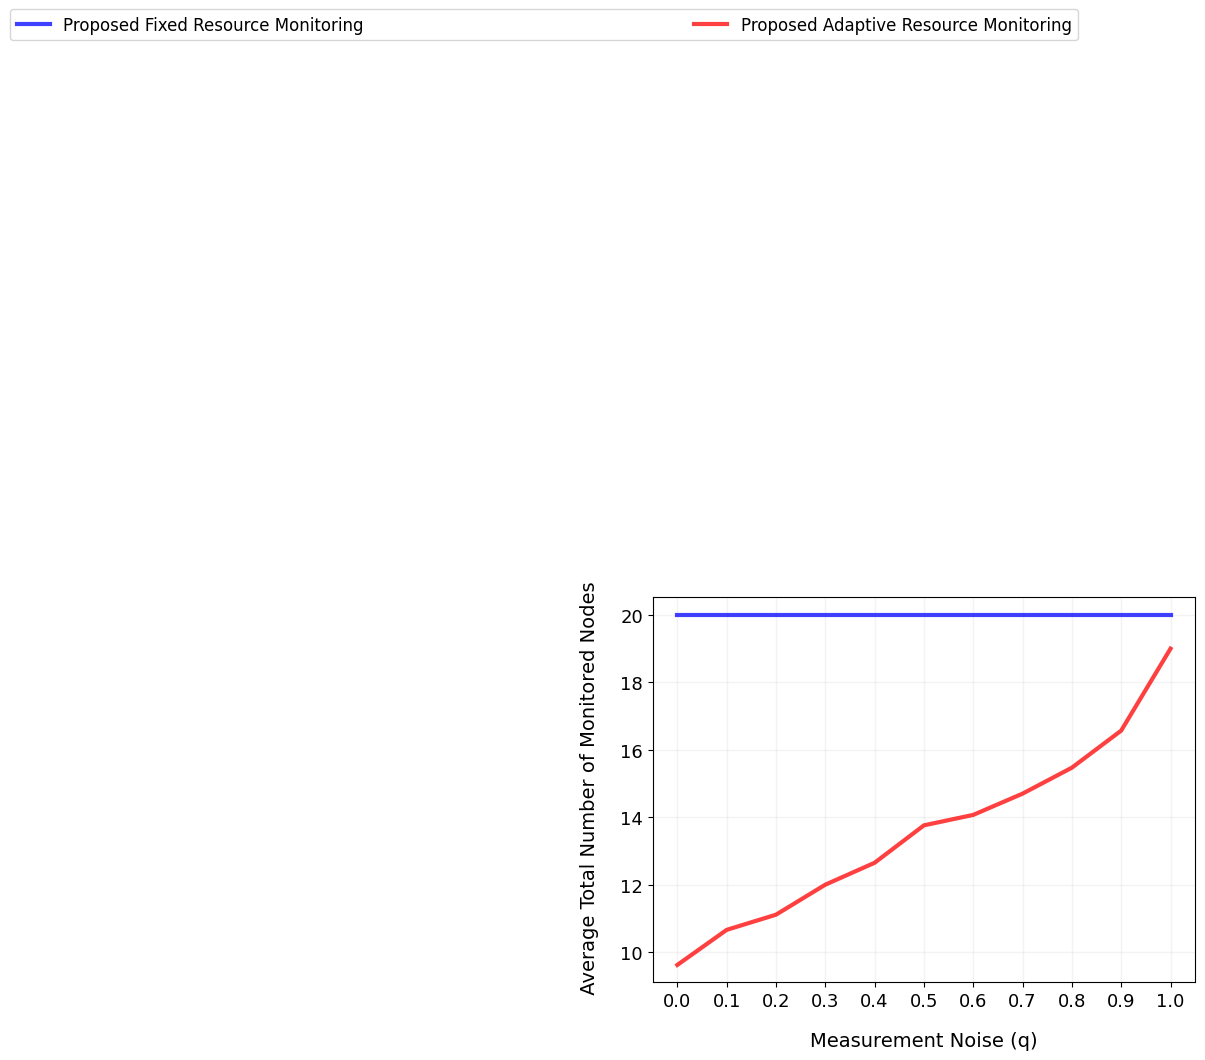

In [ ]:
plt.rcdefaults()
plt.rcParams['figure.figsize'] = [7, 5]
fig1, ax1 = plt.subplots()
fontsize = 14
l = (len(modes)-1)/2
j=0
# Have for diffferent qs.


i=0
num1 = np.zeros(len(q_list))
num2 = np.zeros(len(q_list))
for pack in packed_for_q_list:
  j = 0
  i += 1
  (fixed, ours, random, alll, random_fixed, threshold) = pack
  all_mon_list, mode_label, mode_color= mode_handler('ours', 4)
  for arr in all_mon_list:
    for arr2 in arr:
      num1[i-1] += len(arr2)
  all_mon_list, mode_label, mode_color= mode_handler('threshold', 4)
  for arr in all_mon_list:
    for arr2 in arr:
      num2[i-1] += len(arr2)

num1 = num1/(max_num)
num2 = num2/(max_num)
width = 43  # the width of the bars
q_list = np.array(q_list)
print(q_list)
# mean_mon_list_random_fixed =occurance_random_fixed/max_num
all_mon_list, mode_label, mode_color= mode_handler('ours', 4)
rects2 = ax1.plot(q_list, num1 ,linewidth=3, label=mode_label,color=mode_color, alpha=0.75)
  # mean_mon_list_random_fixed =occurance_random_fixed/max_num
all_mon_list, mode_label, mode_color= mode_handler('threshold', 4)
rects2 = ax1.plot(q_list, num2 ,linewidth=3,label=mode_label,color=mode_color, alpha=0.75)

ax1.set_xticks(q_list)
# ax1.set_yticks(np.arange(0, 22 ))
ax1.yaxis.set_tick_params(labelsize=fontsize-1)
ax1.set_xticklabels(q_list, fontsize=fontsize-1)
ax1.set_ylabel(r' Average Total Number of Monitored Nodes', fontsize=fontsize, labelpad=15)
ax1.set_xlabel(r'Measurement Noise (q)', fontsize=fontsize, labelpad=15)
# ax1.legend(prop={'size': fontsize})
# ax1.legend(bbox_to_anchor=(-1.2, 0.2, 2,2.35), loc='upper center', mode="expand", ncol= 2, prop={'size': fontsize-2})
ax1.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
fig1.tight_layout()
plt.show()

In [ ]:
# plt.rcdefaults()
# plt.rcParams['figure.figsize'] = [20,10]
# fig1, ax1 = plt.subplots()
# fontsize = 22
# l = (len(modes)-1)/2
# j=0
# # Have for diffferent qs.


# i=0
# num1 = np.zeros(len(q_list))
# num2 = np.zeros(len(q_list))
# first_time = False
# for packed_for_q in packed_for_q_list:
#   j = 0
#   i += 1
#   for pack in packed_for_q:
#     (fixed, ours, random, alll, random_fixed, threshold) = pack
#     all_mon_list, mode_label, mode_color= mode_handler('ours', 4)
#     for arr in all_mon_list:
#       for arr2 in arr:
#         num1[i-1] += len(arr2)
#     all_mon_list, mode_label, mode_color= mode_handler('threshold', 4)
#     for arr in all_mon_list:
#       for arr2 in arr:
#         num2[i-1] += len(arr2)
#     if first_time:
#       break
#     if i == 3:
#       first_time = True
#       num1[i-1] = 0
#       num2[i-1] = 0
#       continue
#     break

# num1 = num1/(max_num)
# num2 = num2/(max_num)

# width = 43  # the width of the bars
# q_list = np.array(q_list)
# print(q_list)
# # mean_mon_list_random_fixed =occurance_random_fixed/max_num
# all_mon_list, mode_label, mode_color= mode_handler('ours', 4)
# rects2 = ax1.plot(q_list, num1 ,linewidth=3, label=mode_label,color=mode_color, alpha=0.75)
#   # mean_mon_list_random_fixed =occurance_random_fixed/max_num
# all_mon_list, mode_label, mode_color= mode_handler('threshold', 4)
# rects2 = ax1.plot(q_list, num2 ,linewidth=3,label=mode_label,color=mode_color, alpha=0.75)

# ax1.set_xticks(q_list)
# # ax1.set_yticks(np.arange(0, 22 ))
# ax1.yaxis.set_tick_params(labelsize=fontsize-1)
# ax1.set_xticklabels(q_list, fontsize=fontsize-1)
# ax1.set_ylabel(r' Average Total Number of Monitored Nodes', fontsize=fontsize, labelpad=15)
# ax1.set_xlabel(r'Measurement Noise (q)', fontsize=fontsize, labelpad=15)
# ax1.legend(prop={'size': fontsize})
# ax1.grid(color='gray', linestyle='-', linewidth=1, alpha=0.09)
# fig1.tight_layout()
# plt.show()

In [ ]:
X = np.array([0, 0, 1, 1, 0])
Y = np.array([0, 0, 0, 0, 0])
a = np.array([1])
res = np.zeros(5)
print(a[0])

1


In [ ]:
res[a][(X[a]==0) & (Y[a]==0)] = 2

In [ ]:
print(res[a])
print(X[a]==0)
print(Y[a]==0)

[0.]
[ True]
[ True]


In [ ]:
res_a = res[a]
res_a[(X[a]==0) & (Y[a]==0)] = 2
print(res_a)

[2.]


In [ ]:
res[a][(X[a]==0) & (Y[a]==0)] = 3
print(res[a])

[0. 0. 0.]


In [ ]:
X = np.array([[0, 1, 3],[ 2, 4, 5]])

print(X[1])

[2 4 5]
